In [1]:
import pandas as pd
import numpy as np
import timeit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
from tensorflow.keras.utils import plot_model

# Loading the dataset
df = pd.read_csv(r'data_with_new_features.csv', delimiter = ',')

In [2]:
df

,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),...,Tuition fees up to date,Gender,Scholarship holder,International,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Target,age_bins,Admission grade (bins),Previous grade (bins)
0,127.3,3.044522,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0.000000,0.000000,Dropout,1,3,1
1,142.5,2.995732,0.0,1.945910,6.0,6.0,0.0,0.0,6.0,6.0,...,0,1,0,0,2.708050,2.685577,Graduate,0,4,6
2,124.8,2.995732,0.0,1.945910,0.0,0.0,0.0,0.0,6.0,0.0,...,0,1,0,0,0.000000,0.000000,Dropout,0,2,1
3,119.6,3.044522,0.0,1.945910,8.0,6.0,0.0,0.0,6.0,10.0,...,1,0,0,0,2.669210,2.595255,Graduate,1,2,1
4,141.5,3.828641,0.0,1.945910,9.0,5.0,0.0,0.0,6.0,6.0,...,1,0,0,0,2.590267,2.639057,Graduate,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,122.2,2.995732,0.0,1.945910,7.0,5.0,0.0,0.0,6.0,8.0,...,1,1,0,0,2.681022,2.614960,Graduate,0,2,2
4420,119.0,2.944439,0.0,1.945910,6.0,6.0,0.0,0.0,6.0,6.0,...,0,0,0,1,2.564949,2.484907,Dropout,0,2,1
4421,149.5,3.433987,0.0,2.079442,8.0,7.0,0.0,0.0,8.0,9.0,...,1,0,1,0,2.767105,2.674149,Dropout,3,5,5
4422,153.8,3.044522,0.0,1.791759,5.0,5.0,0.0,0.0,5.0,6.0,...,1,0,1,0,2.694627,2.564949,Graduate,1,5,7


In [3]:
# Splitting the dataset to hold the independent and target variables where X represents the independent variable and y the target variable.
X = df.drop('Target', axis=1)
y = df['Target']
y = y.replace({'Dropout': 1, 'Enrolled': 0, 'Graduate': 0})

In [4]:
# Splitting the dataset into train, validation and test dataset 60%-20%-20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=105)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=105)

In [5]:
x_eval = pd.concat([x_train, x_val])
y_eval = pd.concat([y_train, y_val])

In [52]:
def model_training(clf, X_tr, y_tr, X_te, y_te, phase, svc=False):
    '''A function to train a model and evaluate it based on various metrics'''
    #Calculate start time
    start_train = timeit.default_timer()

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_tr,y_tr)

    #Calculate Stop time for training
    stop_train = timeit.default_timer()
    train_time= stop_train - start_train
    
    
#     #Calculate start time for prediction
#     start = timeit.default_timer()

#     # Predict the model
#     pred_class =clf.predict(X_te)

#     #Calculate Stop time
#     stop = timeit.default_timer()
#     test_time= stop - start
    
    print('Train Time(s):', train_time)

#     #Test time
#     print('Test Time(s):',test_time)
    
    train_pred = clf.predict(X_tr)
    
    train_acc = accuracy_score(y_tr, train_pred)
    
    print('Training Accuracy:  {}%'.format(round(train_acc, 2)*100))
    
    model_evaluation(clf, X_te, y_te, phase,svc)

In [47]:
def model_evaluation(clf, X_te, y_te, phase, svc=False):
    print('\n Model Evaluation Result For the {} Phase \n'.format(phase))
    #Calculate start time for prediction
    start = timeit.default_timer()
        # Predict the model
    pred_class =clf.predict(X_te)

    #Calculate Stop time
    stop = timeit.default_timer()
    test_time= stop - start
    
#     print('Train Time(s):', train_time)

    #Test time
    print('Test Time(s):',test_time)
    
#     train_pred = clf.predict(X_tr)
    
#     train_acc = accuracy_score(y_tr, train_pred)
    
#     print('Training Accuracy:  {}%\n'.format(round(train_acc, 2)*100))
    
    accuracy = accuracy_score(y_te, pred_class)
    
    report = classification_report(y_te, pred_class)
    
    print('Accuracy:  {}%\n'.format(round(accuracy, 2)*100))
    
    print(report, '\n')
    
    cf_matrix = confusion_matrix(y_te, pred_class)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    if svc:
        y_pred_proba = clf.decision_function(X_te)
    else:
        y_pred_proba = clf.predict_proba(X_te)[::,1]
    # Calculate False Positive Rate, True Positive Rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [53]:
def model_tuning(clf, parameters, train_feat, train_labels, val_feat, val_labels, cv, svc = False):
    grid_search = GridSearchCV(clf, parameters,cv=cv,
                               n_jobs=-1, scoring='accuracy', verbose=1)
    grid_search.fit(train_feat, train_labels)
    model_training(grid_search.best_estimator_, train_feat, train_labels, val_feat, val_labels, phase = 'Tuning', svc = svc)
    return grid_search.best_estimator_

In [9]:
from sklearn.model_selection import cross_val_score

cv = 5
def cross_validation(clf_model, features, labels, cv):
    scores = cross_val_score(
      clf_model, features,
      labels,
      scoring="accuracy", cv=cv)
    acc_scores = scores
    print("Scores:", acc_scores)
    print("Mean:", acc_scores.mean())
    print("StandardDeviation:", acc_scores.std())

In [10]:
def save_model(model, filename):
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model saved successfully to {filename}")
    except Exception as e:
        print(f"Error saving model: {e}")


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Logistic Regression

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Create the pipeline
pipeline_log = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', LogisticRegression(max_iter = 10000, random_state = 105))  # Step 2: Apply Logistic Regression
])



Train Time(s): 0.3852500000502914
Training Accuracy:  89.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.011153799947351217
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



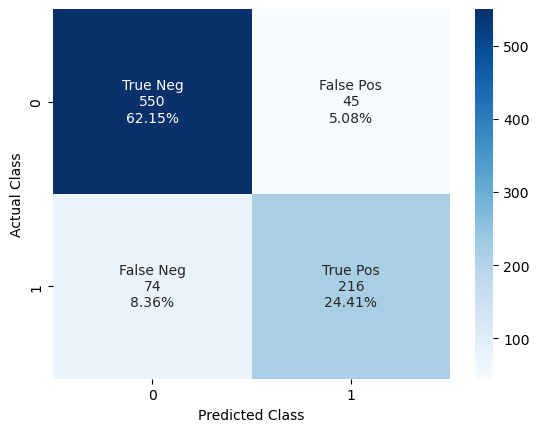

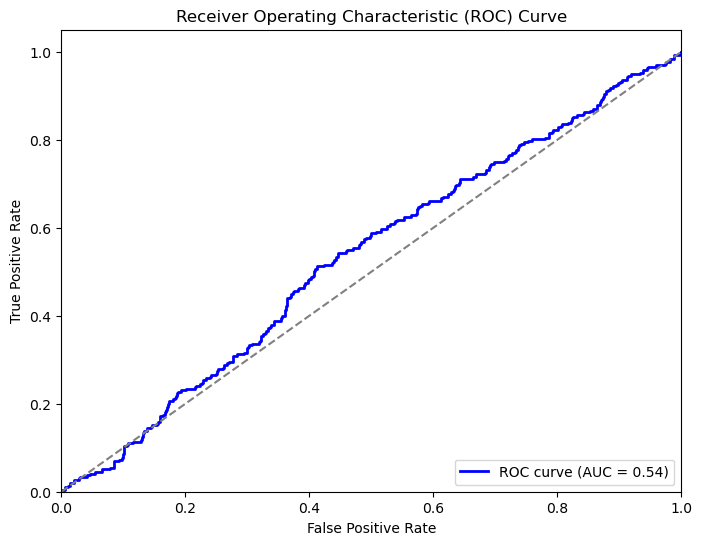

In [13]:
#log = LogisticRegression(max_iter = 10000, random_state = 105)
model_training(pipeline_log, x_train, y_train, x_val, y_val, phase = 'Training')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Train Time(s): 24.45606550015509
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.010232999920845032
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.74      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



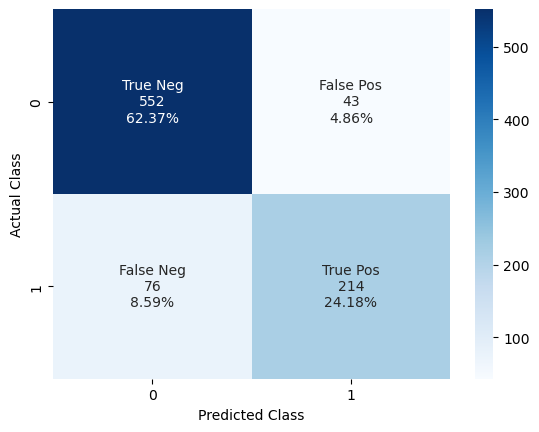

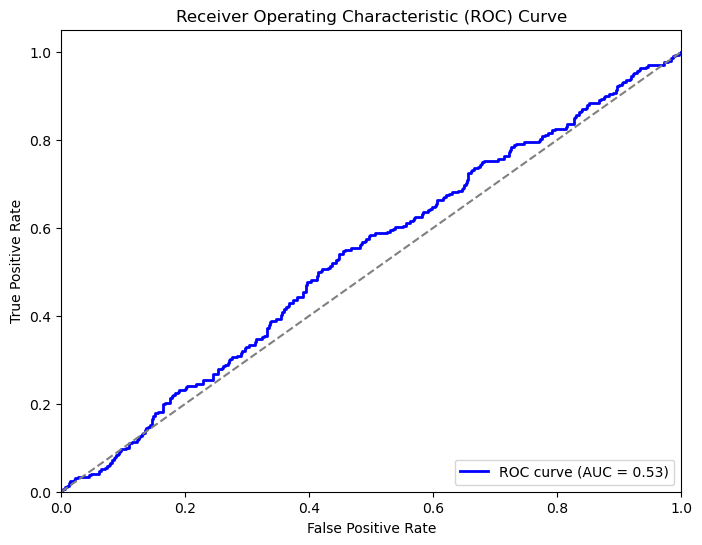

In [14]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100], 
    'classifier__penalty': ['l1', 'l2'], 
    'classifier__solver': ['liblinear', 'saga', ]
}

best_log_model = model_tuning(pipeline_log, parameters = param_grid, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 5)


In [15]:
cross_validation(best_log_model, x_eval, y_eval, cv)

Scores: [0.88418079 0.86299435 0.88700565 0.88135593 0.86138614]
Mean: 0.8753845723555406
StandardDeviation: 0.010932097598088544



 Model Evaluation Result For the Test Phase 

Test Time(s): 0.01227349997498095
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.71      0.79       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.85       885
weighted avg       0.87      0.87      0.87       885
 



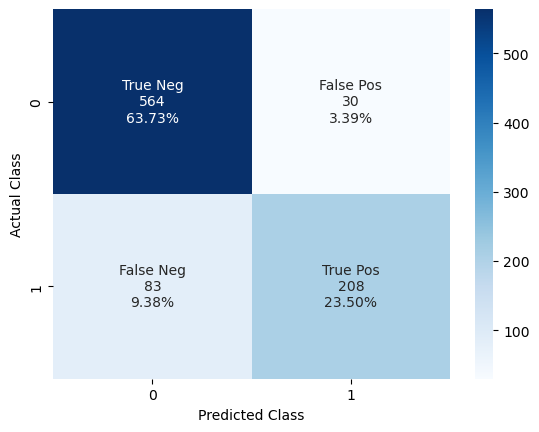

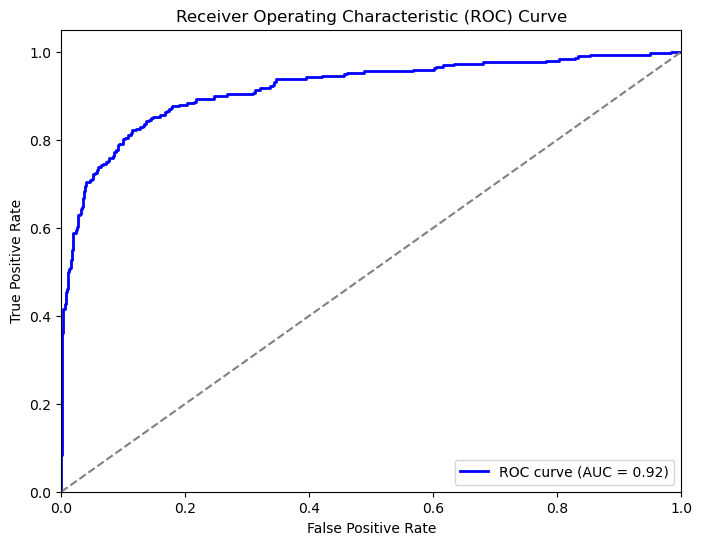

In [16]:
model_evaluation(best_log_model, x_test, y_test, phase = 'Test')

In [17]:
save_model(best_log_model, 'logistic_regression.pkl')

Model saved successfully to logistic_regression.pkl


# Decision Tree Classifier

In [18]:
# Create the pipeline
pipeline_dt = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', DecisionTreeClassifier(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 0.9505076999776065
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.010143599938601255
Accuracy:  80.0%

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       595
           1       0.69      0.71      0.70       290

    accuracy                           0.80       885
   macro avg       0.78      0.78      0.78       885
weighted avg       0.80      0.80      0.80       885
 



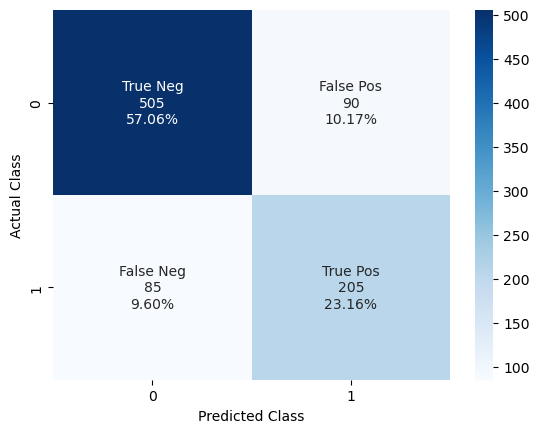

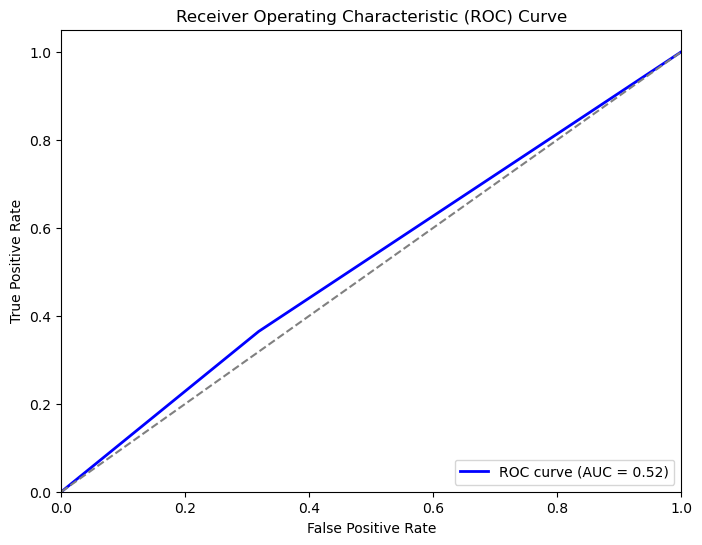

In [19]:
model_training(pipeline_dt, x_train, y_train, x_val, y_val, phase = 'Training')

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Train Time(s): 0.03242449997924268
Training Accuracy:  88.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.009066700004041195
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       595
           1       0.77      0.70      0.73       290

    accuracy                           0.83       885
   macro avg       0.81      0.80      0.80       885
weighted avg       0.83      0.83      0.83       885
 



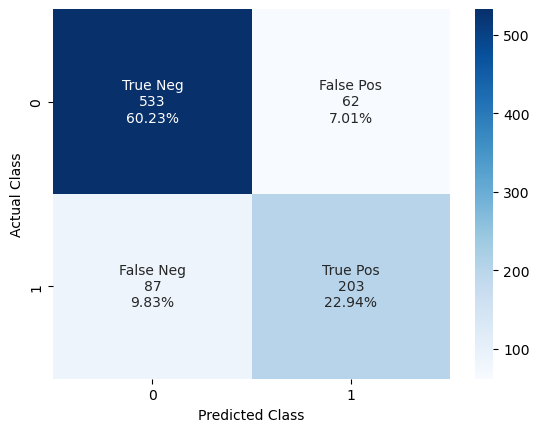

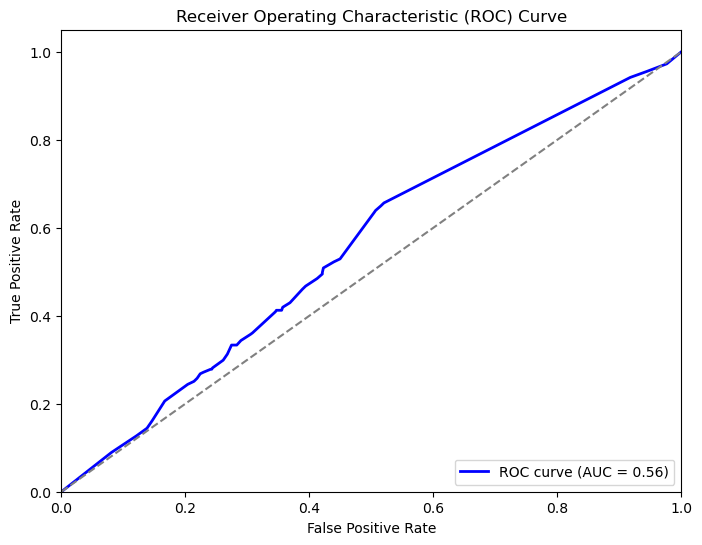

In [20]:
param_grid_dt = {
    "classifier__min_samples_leaf": [2, 3, 5, 7],
    "classifier__max_depth": [5, 7, 9, 15],
    "classifier__min_samples_leaf": [2, 3, 7, 9, 11],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__criterion": ['gini', 'entropy']
}
best_dt_model = model_tuning(pipeline_dt, parameters = param_grid_dt, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3)

In [21]:
cross_validation(best_dt_model, x_eval, y_eval, cv)

Scores: [0.86723164 0.83898305 0.86581921 0.85310734 0.85714286]
Mean: 0.856456820016142
StandardDeviation: 0.010205618854962564



 Model Evaluation Result For the Test Phase 

Test Time(s): 0.014177200151607394
Accuracy:  83.0%

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       594
           1       0.77      0.67      0.72       291

    accuracy                           0.83       885
   macro avg       0.81      0.79      0.80       885
weighted avg       0.83      0.83      0.82       885
 



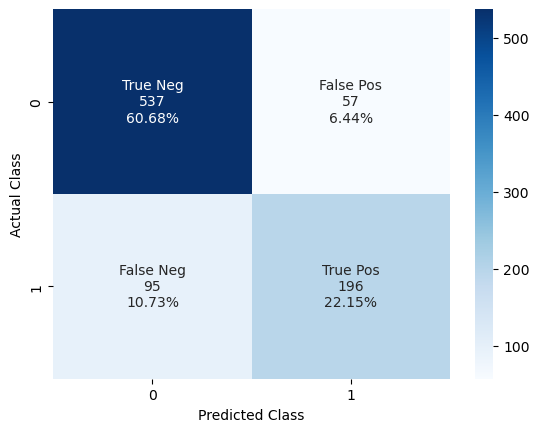

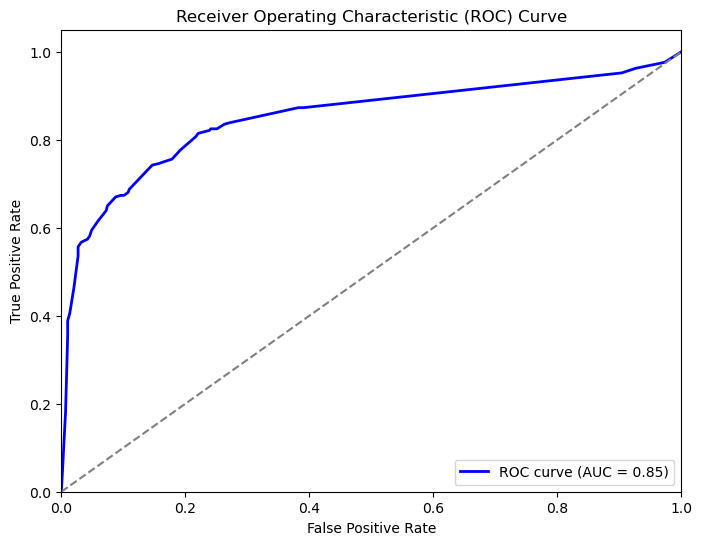

In [22]:
model_evaluation(best_dt_model, x_test, y_test, phase = 'Test')

In [23]:
save_model(best_dt_model, 'decision_tree.pkl')

Model saved successfully to decision_tree.pkl


# Random Forest Classifier

In [24]:
# Create the pipeline
pipeline_rf = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', RandomForestClassifier(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 2.599414300173521
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.03833250002935529
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       595
           1       0.82      0.72      0.77       290

    accuracy                           0.86       885
   macro avg       0.84      0.82      0.83       885
weighted avg       0.85      0.86      0.85       885
 



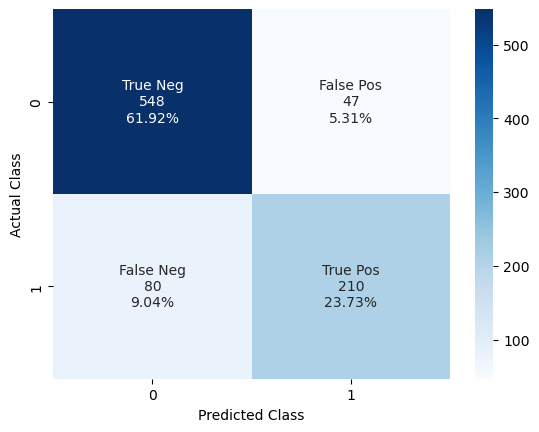

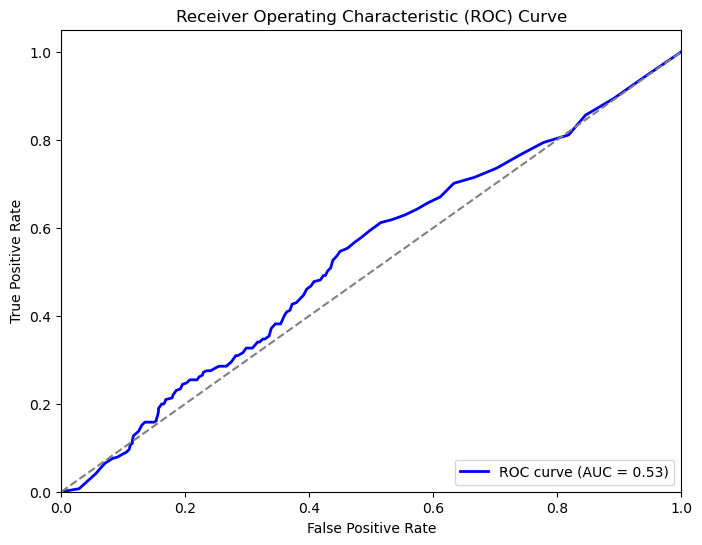

In [25]:
model_training(pipeline_rf, x_train, y_train, x_val, y_val, phase= 'Training')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Train Time(s): 2.744742800015956
Training Accuracy:  95.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.03539410000666976
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.83      0.73      0.78       290

    accuracy                           0.86       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



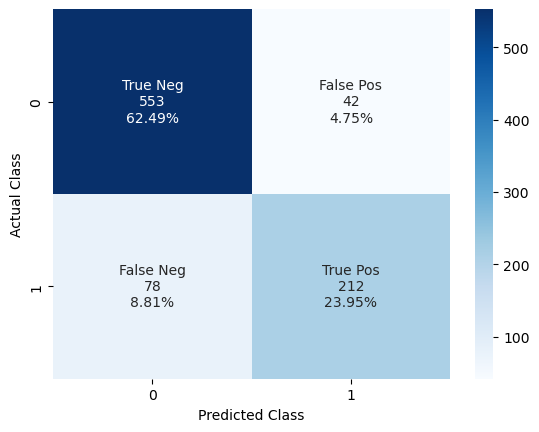

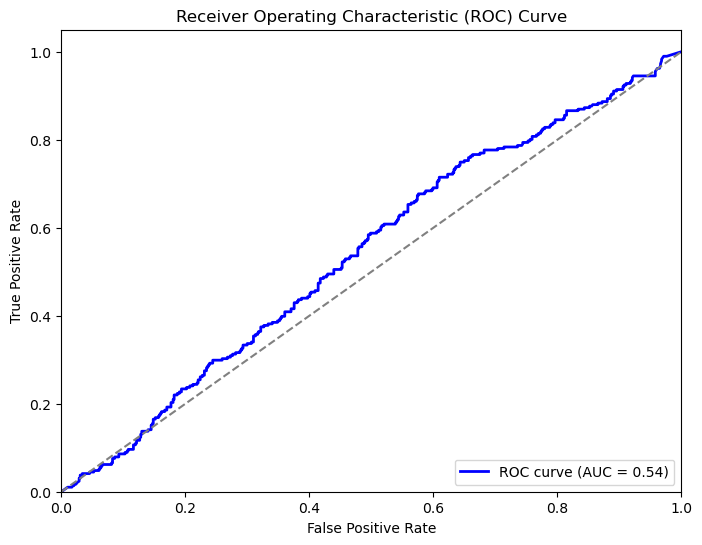

In [26]:
param_grid_rf = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_features": [5, 10, 20],
    "classifier__min_samples_leaf": [2, 3, 7]
}

best_rf_model = model_tuning(pipeline_rf, parameters = param_grid_rf, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3)

In [27]:
cross_validation(best_rf_model, x_eval, y_eval, cv)

Scores: [0.88276836 0.84463277 0.87853107 0.86581921 0.86138614]
Mean: 0.866627510208648
StandardDeviation: 0.013521212199364434



 Model Evaluation Result For the Test Phase 

Test Time(s): 0.06837970018386841
Accuracy:  85.0%

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       594
           1       0.84      0.67      0.75       291

    accuracy                           0.85       885
   macro avg       0.85      0.80      0.82       885
weighted avg       0.85      0.85      0.84       885
 



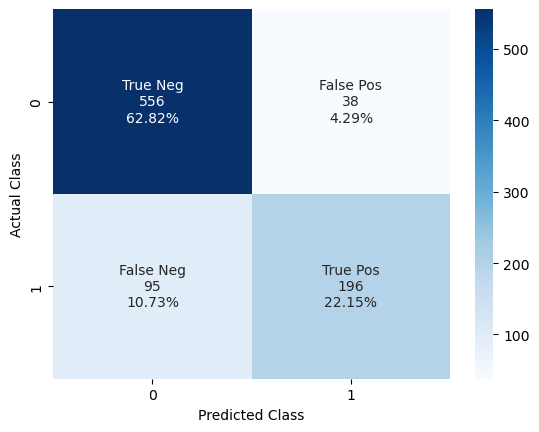

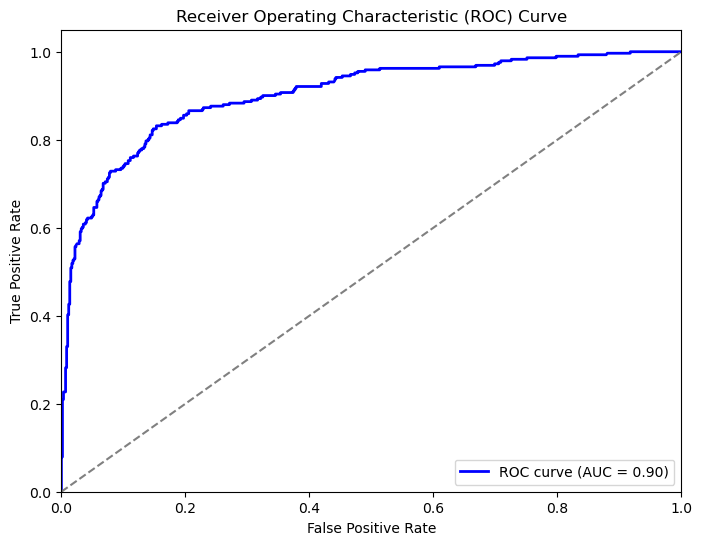

In [28]:
model_evaluation(best_rf_model, x_test, y_test, phase = 'Test')

In [29]:
save_model(best_rf_model, 'random_forest.pkl')

Model saved successfully to random_forest.pkl


# Support Vector Machine 

In [30]:
# Create the pipeline
pipeline_svc = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', SVC(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 0.962993900058791
Training Accuracy:  88.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.34440220007672906
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.90       595
           1       0.86      0.70      0.77       290

    accuracy                           0.87       885
   macro avg       0.86      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



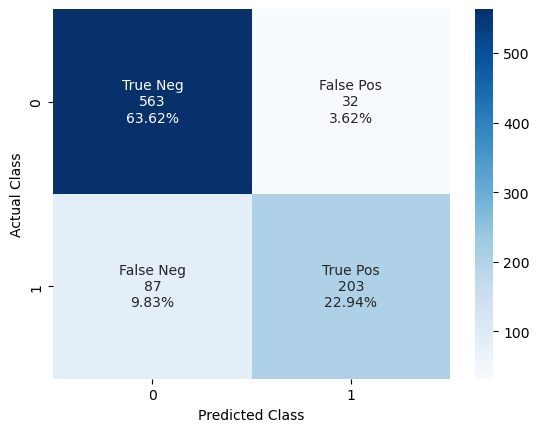

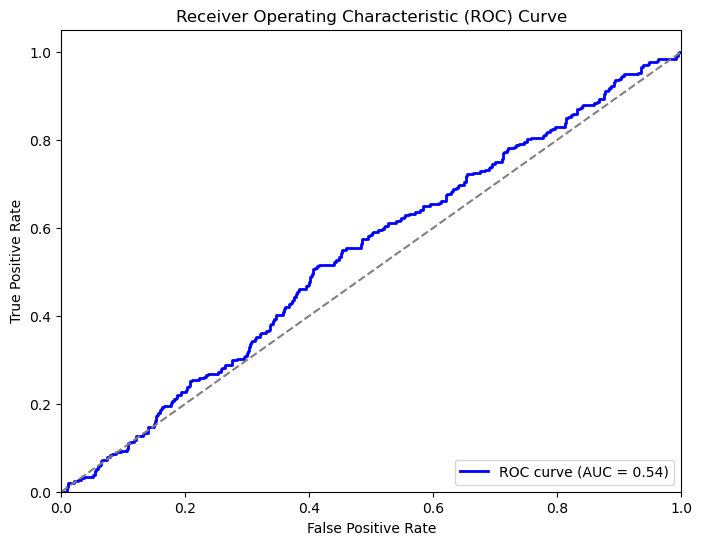

In [54]:
model_training(pipeline_svc, x_train, y_train, x_val, y_val, svc = True, phase = 'Training')

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Train Time(s): 0.779193899827078
Training Accuracy:  91.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.3169074999168515
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       595
           1       0.85      0.72      0.78       290

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



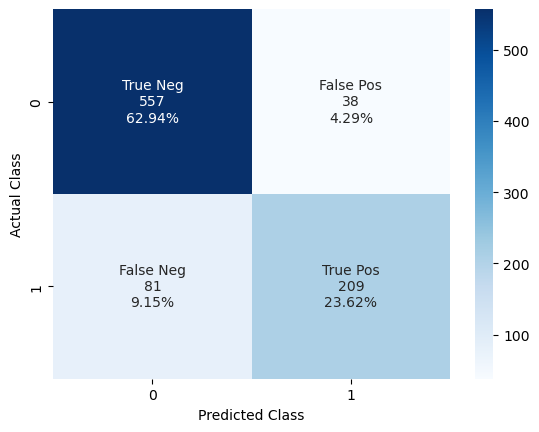

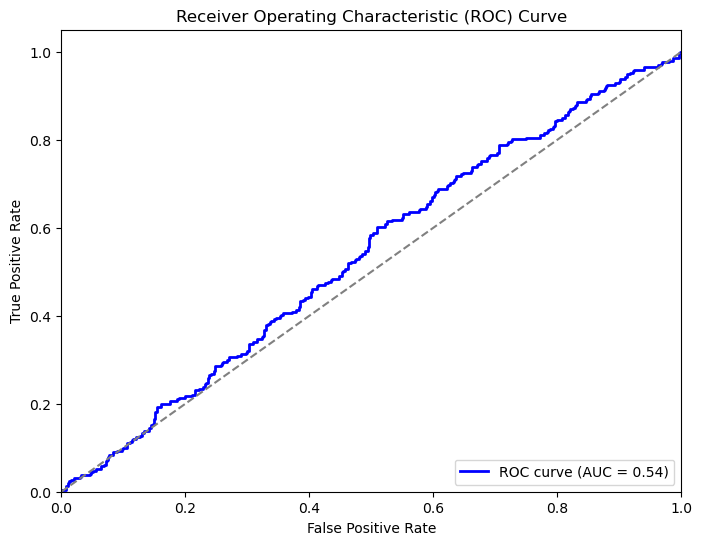

In [56]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.5, 0.01, 0.001],
    'classifier__kernel': ['linear', 'rbf']
}
best_svc_model = model_tuning(pipeline_svc, parameters = param_grid_svc, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3, svc = True)

In [57]:
cross_validation(best_svc_model, x_eval, y_eval, cv)

Scores: [0.88135593 0.85310734 0.88276836 0.87570621 0.86421499]
Mean: 0.8714305692070419
StandardDeviation: 0.011252951707660446



 Model Evaluation Result For the Test Phase 

Test Time(s): 0.370468300068751
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.90       594
           1       0.86      0.70      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.87      0.87      0.86       885
 



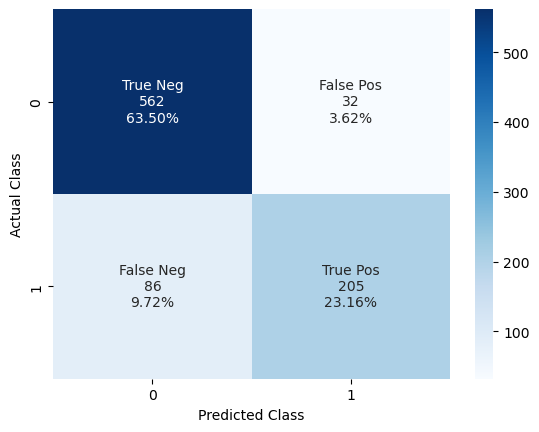

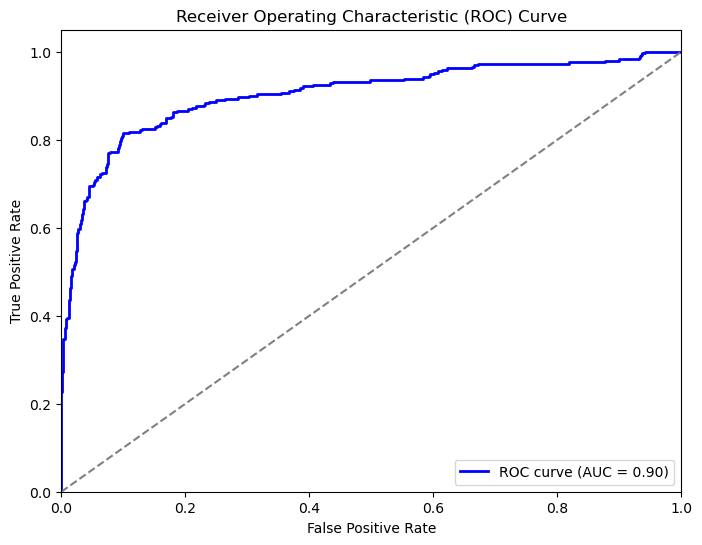

In [58]:
model_evaluation(best_svc_model, X_te = x_test, y_te = y_test, phase = 'Test', svc = True)

In [59]:
save_model(best_svc_model, 'svc.pkl')

Model saved successfully to svc.pkl


# Gradient Boosting Classifier

In [60]:
# Create the pipeline
pipeline_gdb = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Scale features to a range (0, 1)
    ('classifier', GradientBoostingClassifier(random_state = 105))  # Step 2: Apply Logistic Regression
])

Train Time(s): 10.989162700017914
Training Accuracy:  93.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.011565399821847677
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.82      0.74      0.78       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



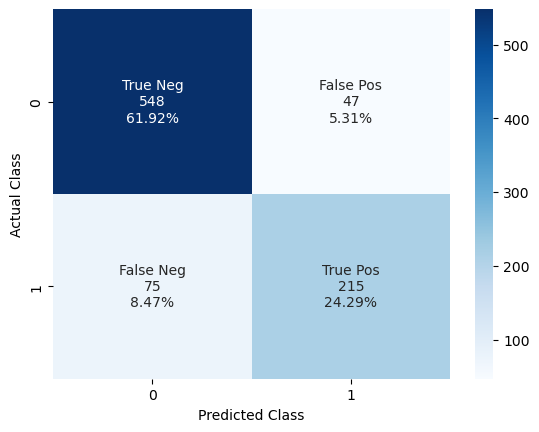

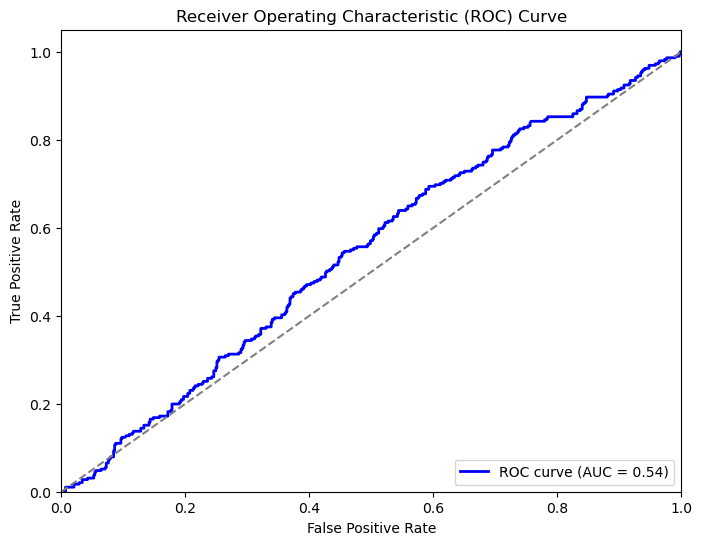

In [61]:
model_training(pipeline_gdb, x_train, y_train, x_val, y_val, phase = 'Training')

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Train Time(s): 4.642063499893993
Training Accuracy:  89.0%

 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.013926599873229861
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       595
           1       0.84      0.74      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



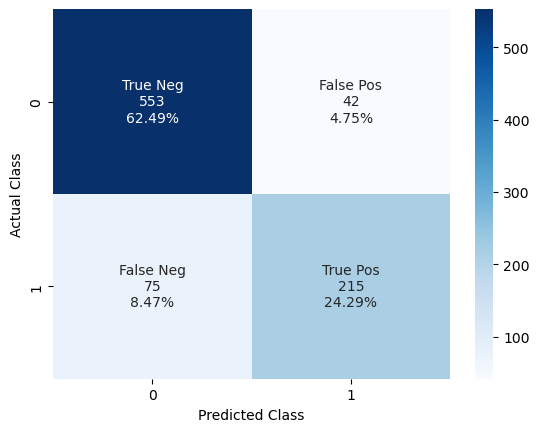

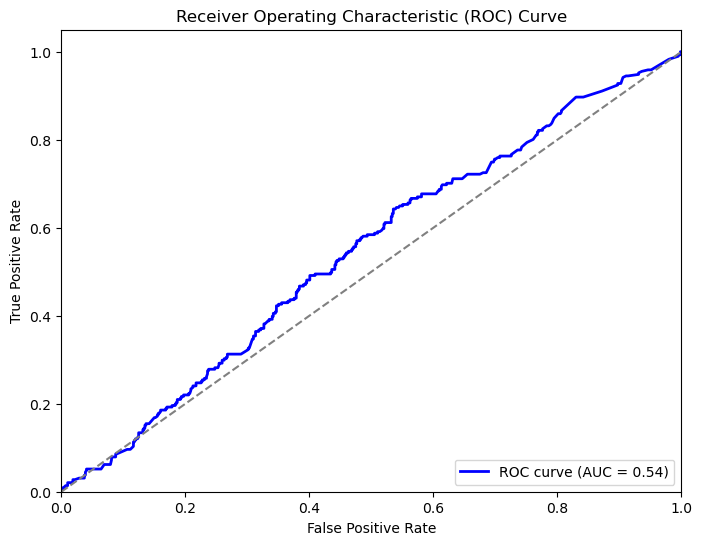

In [62]:
param_grid_gdb = {
    "classifier__n_estimators":[50,100, 200],
    "classifier__max_depth":[2, 3],
    "classifier__min_samples_split":[5, 7, 8],
    "classifier__subsample": [0.8, 0.9, 1.0],
    
}

best_gdb_model = model_tuning(pipeline_gdb, parameters = param_grid_gdb, train_feat = x_train,
                              train_labels = y_train, val_feat = x_val, val_labels = y_val, cv = 3)

In [63]:
cross_validation(best_gdb_model, x_eval, y_eval, cv)

Scores: [0.88418079 0.86016949 0.88276836 0.8799435  0.87128713]
Mean: 0.8756698551211054
StandardDeviation: 0.00895051339197117



 Model Evaluation Result For the Test Phase 

Test Time(s): 0.017665899824351072
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.86      0.69      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



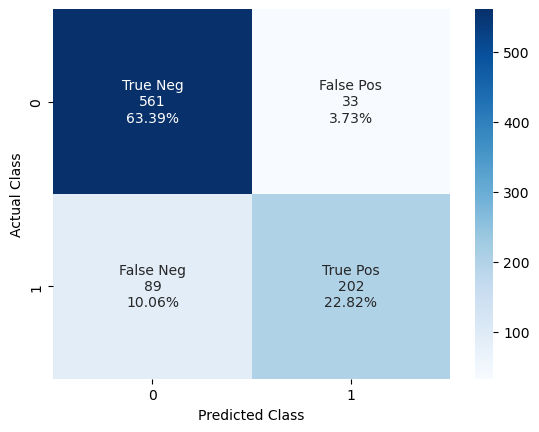

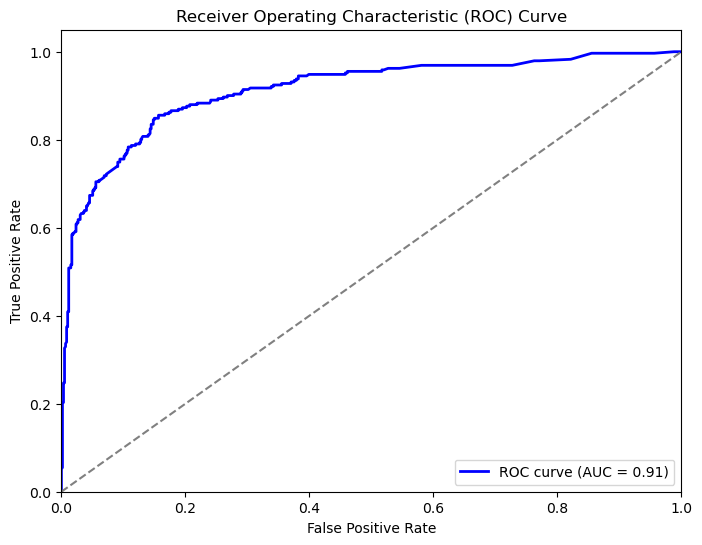

In [64]:
model_evaluation(best_gdb_model, X_te = x_test, y_te = y_test, phase = 'Test')

In [65]:
save_model(best_gdb_model, 'gradient_boost.pkl')

Model saved successfully to gradient_boost.pkl


# Catboost Classifier

In [66]:
cat = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.01, 
    random_state = 105
)
pipeline_cat = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', cat)  
])

0:	learn: 0.6853807	total: 380ms	remaining: 3m 9s
1:	learn: 0.6785608	total: 428ms	remaining: 1m 46s
2:	learn: 0.6710883	total: 477ms	remaining: 1m 19s
3:	learn: 0.6645384	total: 526ms	remaining: 1m 5s
4:	learn: 0.6563307	total: 595ms	remaining: 58.9s
5:	learn: 0.6493245	total: 675ms	remaining: 55.6s
6:	learn: 0.6437971	total: 747ms	remaining: 52.6s
7:	learn: 0.6362767	total: 855ms	remaining: 52.6s
8:	learn: 0.6292765	total: 960ms	remaining: 52.4s
9:	learn: 0.6230325	total: 1.03s	remaining: 50.3s
10:	learn: 0.6164111	total: 1.11s	remaining: 49.2s
11:	learn: 0.6105756	total: 1.16s	remaining: 47.3s
12:	learn: 0.6049366	total: 1.21s	remaining: 45.5s
13:	learn: 0.5994581	total: 1.26s	remaining: 43.8s
14:	learn: 0.5938372	total: 1.42s	remaining: 45.9s
15:	learn: 0.5880203	total: 1.53s	remaining: 46.4s
16:	learn: 0.5817655	total: 1.58s	remaining: 45s
17:	learn: 0.5756376	total: 1.63s	remaining: 43.8s
18:	learn: 0.5703278	total: 1.7s	remaining: 43s
19:	learn: 0.5651264	total: 1.75s	remaining:

165:	learn: 0.3196977	total: 12.1s	remaining: 24.4s
166:	learn: 0.3193017	total: 12.2s	remaining: 24.3s
167:	learn: 0.3187656	total: 12.2s	remaining: 24.1s
168:	learn: 0.3181196	total: 12.2s	remaining: 24s
169:	learn: 0.3176466	total: 12.3s	remaining: 23.8s
170:	learn: 0.3173201	total: 12.3s	remaining: 23.7s
171:	learn: 0.3169238	total: 12.3s	remaining: 23.5s
172:	learn: 0.3165082	total: 12.4s	remaining: 23.4s
173:	learn: 0.3160053	total: 12.4s	remaining: 23.3s
174:	learn: 0.3157599	total: 12.5s	remaining: 23.1s
175:	learn: 0.3154453	total: 12.5s	remaining: 23s
176:	learn: 0.3149055	total: 12.5s	remaining: 22.9s
177:	learn: 0.3144389	total: 12.6s	remaining: 22.8s
178:	learn: 0.3139449	total: 12.7s	remaining: 22.7s
179:	learn: 0.3136056	total: 12.7s	remaining: 22.6s
180:	learn: 0.3132306	total: 12.7s	remaining: 22.4s
181:	learn: 0.3128142	total: 12.8s	remaining: 22.3s
182:	learn: 0.3124393	total: 12.8s	remaining: 22.2s
183:	learn: 0.3120241	total: 12.9s	remaining: 22.1s
184:	learn: 0.31

326:	learn: 0.2763769	total: 19.6s	remaining: 10.3s
327:	learn: 0.2760662	total: 19.6s	remaining: 10.3s
328:	learn: 0.2758987	total: 19.6s	remaining: 10.2s
329:	learn: 0.2757521	total: 19.7s	remaining: 10.1s
330:	learn: 0.2756493	total: 19.7s	remaining: 10.1s
331:	learn: 0.2755087	total: 19.8s	remaining: 10s
332:	learn: 0.2754517	total: 19.8s	remaining: 9.93s
333:	learn: 0.2752515	total: 19.8s	remaining: 9.86s
334:	learn: 0.2751390	total: 19.9s	remaining: 9.79s
335:	learn: 0.2749887	total: 19.9s	remaining: 9.72s
336:	learn: 0.2748910	total: 19.9s	remaining: 9.65s
337:	learn: 0.2746669	total: 20s	remaining: 9.57s
338:	learn: 0.2745341	total: 20s	remaining: 9.51s
339:	learn: 0.2743721	total: 20.1s	remaining: 9.44s
340:	learn: 0.2741739	total: 20.1s	remaining: 9.37s
341:	learn: 0.2740633	total: 20.1s	remaining: 9.3s
342:	learn: 0.2739401	total: 20.2s	remaining: 9.23s
343:	learn: 0.2737696	total: 20.2s	remaining: 9.16s
344:	learn: 0.2737194	total: 20.2s	remaining: 9.09s
345:	learn: 0.27350

487:	learn: 0.2534740	total: 27.2s	remaining: 670ms
488:	learn: 0.2534187	total: 27.3s	remaining: 614ms
489:	learn: 0.2533252	total: 27.4s	remaining: 559ms
490:	learn: 0.2531290	total: 27.4s	remaining: 503ms
491:	learn: 0.2528788	total: 27.5s	remaining: 447ms
492:	learn: 0.2526792	total: 27.5s	remaining: 391ms
493:	learn: 0.2525631	total: 27.6s	remaining: 335ms
494:	learn: 0.2524590	total: 27.6s	remaining: 279ms
495:	learn: 0.2522966	total: 27.6s	remaining: 223ms
496:	learn: 0.2521912	total: 27.7s	remaining: 167ms
497:	learn: 0.2520999	total: 27.8s	remaining: 111ms
498:	learn: 0.2519640	total: 27.8s	remaining: 55.8ms
499:	learn: 0.2517933	total: 27.9s	remaining: 0us
Train Time(s): 30.433747499948367
Training Accuracy:  91.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.02227570000104606
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       595
           1       0.85      0.73      0.79       290

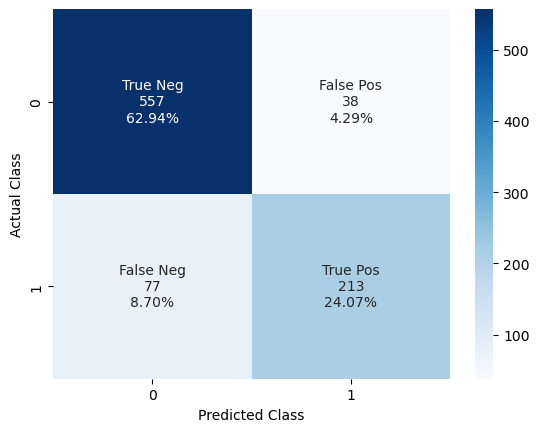

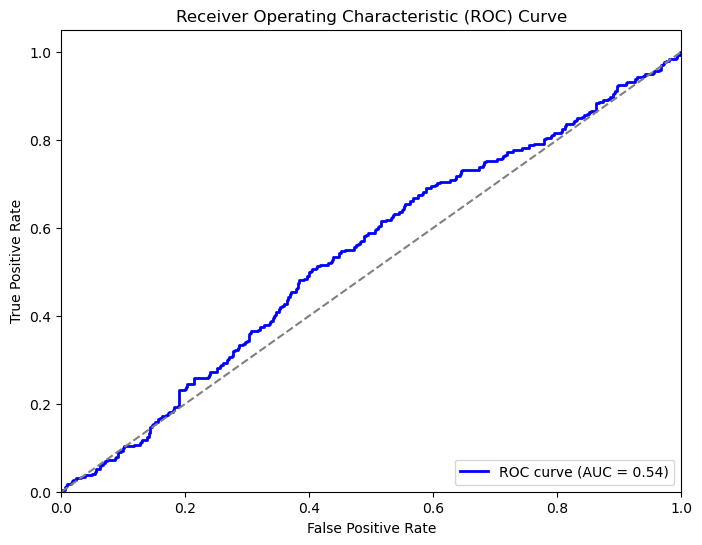

In [67]:
model_training(pipeline_cat, x_train, y_train, x_val, y_val, phase = 'Training')

In [68]:
param_grid_cat = {
    'classifier__iterations': stats.randint(100, 1000),  # Number of boosting iterations
    'classifier__depth': stats.randint(3, 10),           # Depth of the trees
    'classifier__learning_rate': np.linspace(0.01, 0.3), # Learning rate
    'classifier__l2_leaf_reg': stats.uniform(1, 10),     # L2 regularization term on weights
    'classifier__border_count': stats.randint(32, 255),  # Number of splits for features
    'classifier__bagging_temperature': stats.uniform(0, 1), # Controls the strength of the bagging
}

random_search_cat = RandomizedSearchCV(
    pipeline_cat,  # The pipeline containing preprocessing and classification steps
    param_distributions=param_grid_cat,  # The parameter grid for random sampling
    n_iter=10,  # Number of random parameter settings to try
    cv=3,  # Number of cross-validation folds
    scoring= 'accuracy',  # Metric to evaluate the performance of the model
    n_jobs=-1,  # Use all available cores for computation
    verbose=1,  # Verbosity level, set to 1 to get progress updates
    random_state = 105
)

# Fit the RandomizedSearchCV object to the training data
# This will search for the best hyperparameters based on cross-validation performance
random_search_cat.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6865269	total: 19ms	remaining: 11.6s
1:	learn: 0.6793422	total: 35ms	remaining: 10.7s
2:	learn: 0.6723875	total: 52.2ms	remaining: 10.6s
3:	learn: 0.6654890	total: 68.8ms	remaining: 10.5s
4:	learn: 0.6586297	total: 85.5ms	remaining: 10.4s
5:	learn: 0.6516282	total: 108ms	remaining: 10.9s
6:	learn: 0.6453040	total: 127ms	remaining: 11s
7:	learn: 0.6385217	total: 150ms	remaining: 11.3s
8:	learn: 0.6329643	total: 179ms	remaining: 12s
9:	learn: 0.6269027	total: 203ms	remaining: 12.3s
10:	learn: 0.6209764	total: 220ms	remaining: 12s
11:	learn: 0.6158594	total: 245ms	remaining: 12.3s
12:	learn: 0.6101767	total: 304ms	remaining: 14s
13:	learn: 0.6051469	total: 327ms	remaining: 14s
14:	learn: 0.6004773	total: 352ms	remaining: 14.1s
15:	learn: 0.5961096	total: 375ms	remaining: 14s
16:	learn: 0.5910874	total: 400ms	remaining: 14.1s
17:	learn: 0.5856137	total: 423ms	remaining: 14s
18:	learn: 0.5808894	total: 465ms	remaining:

167:	learn: 0.3367456	total: 4.01s	remaining: 10.6s
168:	learn: 0.3363442	total: 4.03s	remaining: 10.6s
169:	learn: 0.3359948	total: 4.06s	remaining: 10.6s
170:	learn: 0.3356267	total: 4.08s	remaining: 10.6s
171:	learn: 0.3352156	total: 4.1s	remaining: 10.5s
172:	learn: 0.3347649	total: 4.12s	remaining: 10.5s
173:	learn: 0.3342466	total: 4.15s	remaining: 10.5s
174:	learn: 0.3339095	total: 4.17s	remaining: 10.5s
175:	learn: 0.3335458	total: 4.2s	remaining: 10.4s
176:	learn: 0.3332009	total: 4.23s	remaining: 10.4s
177:	learn: 0.3329350	total: 4.26s	remaining: 10.4s
178:	learn: 0.3326216	total: 4.28s	remaining: 10.4s
179:	learn: 0.3323719	total: 4.3s	remaining: 10.4s
180:	learn: 0.3320365	total: 4.33s	remaining: 10.3s
181:	learn: 0.3316590	total: 4.36s	remaining: 10.3s
182:	learn: 0.3313994	total: 4.39s	remaining: 10.3s
183:	learn: 0.3311780	total: 4.41s	remaining: 10.3s
184:	learn: 0.3308548	total: 4.44s	remaining: 10.3s
185:	learn: 0.3304961	total: 4.47s	remaining: 10.3s
186:	learn: 0.3

329:	learn: 0.3024778	total: 7.97s	remaining: 6.86s
330:	learn: 0.3023770	total: 8s	remaining: 6.83s
331:	learn: 0.3022677	total: 8.02s	remaining: 6.81s
332:	learn: 0.3022042	total: 8.03s	remaining: 6.78s
333:	learn: 0.3020461	total: 8.05s	remaining: 6.75s
334:	learn: 0.3018560	total: 8.08s	remaining: 6.73s
335:	learn: 0.3016870	total: 8.11s	remaining: 6.71s
336:	learn: 0.3015175	total: 8.13s	remaining: 6.68s
337:	learn: 0.3014049	total: 8.16s	remaining: 6.66s
338:	learn: 0.3012906	total: 8.18s	remaining: 6.63s
339:	learn: 0.3011574	total: 8.2s	remaining: 6.61s
340:	learn: 0.3010508	total: 8.22s	remaining: 6.58s
341:	learn: 0.3009410	total: 8.24s	remaining: 6.55s
342:	learn: 0.3008139	total: 8.26s	remaining: 6.52s
343:	learn: 0.3006647	total: 8.27s	remaining: 6.49s
344:	learn: 0.3005046	total: 8.29s	remaining: 6.46s
345:	learn: 0.3004037	total: 8.31s	remaining: 6.43s
346:	learn: 0.3003048	total: 8.33s	remaining: 6.41s
347:	learn: 0.3001375	total: 8.35s	remaining: 6.38s
348:	learn: 0.30

496:	learn: 0.2847387	total: 11.5s	remaining: 2.7s
497:	learn: 0.2846218	total: 11.5s	remaining: 2.67s
498:	learn: 0.2845295	total: 11.5s	remaining: 2.65s
499:	learn: 0.2844437	total: 11.5s	remaining: 2.63s
500:	learn: 0.2843740	total: 11.5s	remaining: 2.6s
501:	learn: 0.2842517	total: 11.5s	remaining: 2.58s
502:	learn: 0.2841112	total: 11.6s	remaining: 2.56s
503:	learn: 0.2839961	total: 11.6s	remaining: 2.53s
504:	learn: 0.2838877	total: 11.6s	remaining: 2.51s
505:	learn: 0.2838529	total: 11.7s	remaining: 2.49s
506:	learn: 0.2836949	total: 11.7s	remaining: 2.47s
507:	learn: 0.2836295	total: 11.7s	remaining: 2.44s
508:	learn: 0.2835677	total: 11.7s	remaining: 2.42s
509:	learn: 0.2834792	total: 11.8s	remaining: 2.4s
510:	learn: 0.2833620	total: 11.8s	remaining: 2.37s
511:	learn: 0.2833022	total: 11.8s	remaining: 2.35s
512:	learn: 0.2832147	total: 11.8s	remaining: 2.33s
513:	learn: 0.2830965	total: 11.8s	remaining: 2.3s
514:	learn: 0.2830129	total: 11.8s	remaining: 2.28s
515:	learn: 0.28

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x000002C26E854ED0>)]),
                   n_jobs=-1,
                   param_distributions={'classifier__bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C26E5EB990>,
                                        'classifier__border_count': <scipy.stats._distn_i...
       0.12836735, 0.13428571, 0.14020408, 0.14612245, 0.15204082,
       0.15795918, 0.16387755, 0.16979592, 0.17571429, 0.18163265,
       0.18755102, 0.19346939, 0.19938776, 0.20530612, 0.21122449,
       0.21714286, 0.22306122, 0.22897959, 0.23489796, 0.24081633,
       0.24673469, 0.25265306, 0.25857143, 0.2644898 , 0.27040816,
       0.27632653, 0.2822449 , 0.28816327, 0.29408163, 0.3       ])},
                   random_state=105, scoring='accuracy', verbose=1)

In [69]:
best_cat_model = random_search_cat.best_estimator_


 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.07405960001051426
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       595
           1       0.85      0.74      0.79       290

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



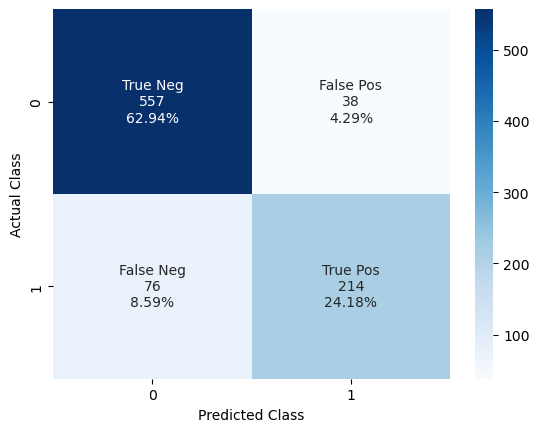

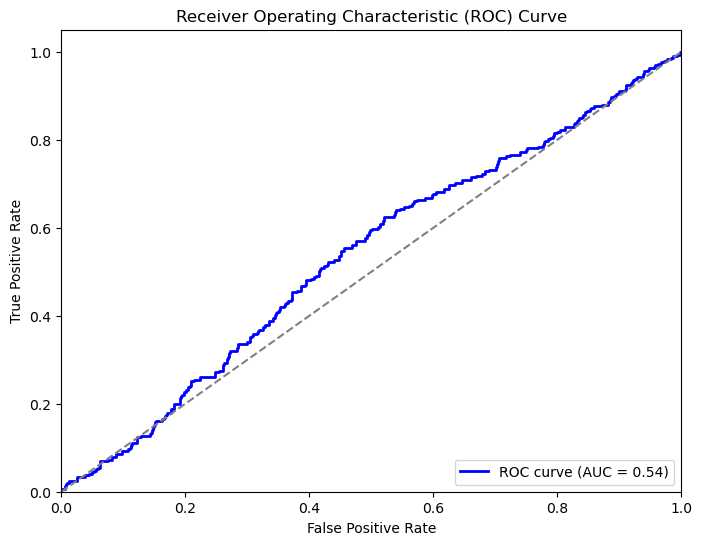

In [70]:
model_evaluation(best_cat_model, X_te = x_val, y_te = y_val, phase = 'Tuning')

In [71]:
cross_validation(best_cat_model, x_eval, y_eval, cv)

0:	learn: 0.6850390	total: 35.9ms	remaining: 22s
1:	learn: 0.6779611	total: 67.1ms	remaining: 20.5s
2:	learn: 0.6710770	total: 96.5ms	remaining: 19.7s
3:	learn: 0.6653012	total: 122ms	remaining: 18.6s
4:	learn: 0.6597107	total: 150ms	remaining: 18.3s
5:	learn: 0.6530278	total: 177ms	remaining: 17.9s
6:	learn: 0.6466588	total: 202ms	remaining: 17.5s
7:	learn: 0.6413270	total: 228ms	remaining: 17.3s
8:	learn: 0.6360906	total: 263ms	remaining: 17.7s
9:	learn: 0.6299650	total: 325ms	remaining: 19.7s
10:	learn: 0.6252256	total: 371ms	remaining: 20.3s
11:	learn: 0.6191005	total: 398ms	remaining: 20s
12:	learn: 0.6145805	total: 435ms	remaining: 20.1s
13:	learn: 0.6090131	total: 464ms	remaining: 19.9s
14:	learn: 0.6035874	total: 511ms	remaining: 20.4s
15:	learn: 0.5977417	total: 538ms	remaining: 20.1s
16:	learn: 0.5930333	total: 567ms	remaining: 19.9s
17:	learn: 0.5886366	total: 597ms	remaining: 19.8s
18:	learn: 0.5840346	total: 634ms	remaining: 19.9s
19:	learn: 0.5789791	total: 669ms	remainin

164:	learn: 0.3497125	total: 4.34s	remaining: 11.8s
165:	learn: 0.3491431	total: 4.37s	remaining: 11.8s
166:	learn: 0.3487368	total: 4.38s	remaining: 11.7s
167:	learn: 0.3482914	total: 4.4s	remaining: 11.7s
168:	learn: 0.3477509	total: 4.42s	remaining: 11.6s
169:	learn: 0.3472884	total: 4.45s	remaining: 11.6s
170:	learn: 0.3469021	total: 4.47s	remaining: 11.6s
171:	learn: 0.3463826	total: 4.5s	remaining: 11.6s
172:	learn: 0.3461647	total: 4.52s	remaining: 11.5s
173:	learn: 0.3458329	total: 4.54s	remaining: 11.5s
174:	learn: 0.3454501	total: 4.56s	remaining: 11.4s
175:	learn: 0.3450947	total: 4.58s	remaining: 11.4s
176:	learn: 0.3447653	total: 4.6s	remaining: 11.3s
177:	learn: 0.3444002	total: 4.61s	remaining: 11.3s
178:	learn: 0.3440207	total: 4.63s	remaining: 11.3s
179:	learn: 0.3436665	total: 4.65s	remaining: 11.2s
180:	learn: 0.3433506	total: 4.67s	remaining: 11.2s
181:	learn: 0.3429592	total: 4.7s	remaining: 11.1s
182:	learn: 0.3425010	total: 4.72s	remaining: 11.1s
183:	learn: 0.34

331:	learn: 0.3126619	total: 7.8s	remaining: 6.62s
332:	learn: 0.3125696	total: 7.82s	remaining: 6.6s
333:	learn: 0.3124882	total: 7.83s	remaining: 6.57s
334:	learn: 0.3123747	total: 7.85s	remaining: 6.54s
335:	learn: 0.3122555	total: 7.86s	remaining: 6.51s
336:	learn: 0.3120938	total: 7.88s	remaining: 6.48s
337:	learn: 0.3119696	total: 7.9s	remaining: 6.45s
338:	learn: 0.3118629	total: 7.91s	remaining: 6.42s
339:	learn: 0.3117630	total: 7.93s	remaining: 6.39s
340:	learn: 0.3116033	total: 7.96s	remaining: 6.37s
341:	learn: 0.3115327	total: 7.99s	remaining: 6.35s
342:	learn: 0.3114100	total: 8.02s	remaining: 6.33s
343:	learn: 0.3113090	total: 8.04s	remaining: 6.31s
344:	learn: 0.3111762	total: 8.06s	remaining: 6.28s
345:	learn: 0.3111141	total: 8.08s	remaining: 6.26s
346:	learn: 0.3110169	total: 8.11s	remaining: 6.24s
347:	learn: 0.3109275	total: 8.12s	remaining: 6.21s
348:	learn: 0.3107530	total: 8.14s	remaining: 6.18s
349:	learn: 0.3106534	total: 8.16s	remaining: 6.15s
350:	learn: 0.3

496:	learn: 0.2960946	total: 11.1s	remaining: 2.6s
497:	learn: 0.2959810	total: 11.1s	remaining: 2.58s
498:	learn: 0.2959265	total: 11.1s	remaining: 2.56s
499:	learn: 0.2958471	total: 11.1s	remaining: 2.54s
500:	learn: 0.2957985	total: 11.1s	remaining: 2.51s
501:	learn: 0.2956813	total: 11.2s	remaining: 2.49s
502:	learn: 0.2956131	total: 11.2s	remaining: 2.46s
503:	learn: 0.2955225	total: 11.2s	remaining: 2.44s
504:	learn: 0.2954212	total: 11.2s	remaining: 2.42s
505:	learn: 0.2953517	total: 11.2s	remaining: 2.4s
506:	learn: 0.2952900	total: 11.3s	remaining: 2.38s
507:	learn: 0.2952261	total: 11.3s	remaining: 2.35s
508:	learn: 0.2951783	total: 11.3s	remaining: 2.33s
509:	learn: 0.2951327	total: 11.3s	remaining: 2.31s
510:	learn: 0.2951045	total: 11.4s	remaining: 2.29s
511:	learn: 0.2950352	total: 11.4s	remaining: 2.27s
512:	learn: 0.2949568	total: 11.4s	remaining: 2.24s
513:	learn: 0.2948781	total: 11.4s	remaining: 2.22s
514:	learn: 0.2947932	total: 11.5s	remaining: 2.2s
515:	learn: 0.2

47:	learn: 0.4699718	total: 878ms	remaining: 10.4s
48:	learn: 0.4667193	total: 899ms	remaining: 10.4s
49:	learn: 0.4640886	total: 915ms	remaining: 10.3s
50:	learn: 0.4615306	total: 931ms	remaining: 10.3s
51:	learn: 0.4597035	total: 946ms	remaining: 10.2s
52:	learn: 0.4570649	total: 961ms	remaining: 10.2s
53:	learn: 0.4544450	total: 979ms	remaining: 10.2s
54:	learn: 0.4520518	total: 1s	remaining: 10.2s
55:	learn: 0.4498589	total: 1.02s	remaining: 10.2s
56:	learn: 0.4474492	total: 1.04s	remaining: 10.2s
57:	learn: 0.4456618	total: 1.06s	remaining: 10.2s
58:	learn: 0.4435025	total: 1.08s	remaining: 10.1s
59:	learn: 0.4415659	total: 1.1s	remaining: 10.2s
60:	learn: 0.4392566	total: 1.13s	remaining: 10.2s
61:	learn: 0.4374709	total: 1.16s	remaining: 10.3s
62:	learn: 0.4356344	total: 1.19s	remaining: 10.4s
63:	learn: 0.4335945	total: 1.22s	remaining: 10.5s
64:	learn: 0.4316786	total: 1.25s	remaining: 10.6s
65:	learn: 0.4295519	total: 1.28s	remaining: 10.6s
66:	learn: 0.4275532	total: 1.31s	r

216:	learn: 0.3209149	total: 4.39s	remaining: 8.03s
217:	learn: 0.3206167	total: 4.42s	remaining: 8.04s
218:	learn: 0.3203453	total: 4.44s	remaining: 8.01s
219:	learn: 0.3200781	total: 4.46s	remaining: 7.99s
220:	learn: 0.3198663	total: 4.49s	remaining: 7.99s
221:	learn: 0.3196568	total: 4.53s	remaining: 7.99s
222:	learn: 0.3194096	total: 4.56s	remaining: 8s
223:	learn: 0.3191823	total: 4.58s	remaining: 7.98s
224:	learn: 0.3189284	total: 4.6s	remaining: 7.95s
225:	learn: 0.3186855	total: 4.62s	remaining: 7.93s
226:	learn: 0.3185601	total: 4.64s	remaining: 7.9s
227:	learn: 0.3183916	total: 4.65s	remaining: 7.88s
228:	learn: 0.3182184	total: 4.67s	remaining: 7.85s
229:	learn: 0.3179016	total: 4.69s	remaining: 7.83s
230:	learn: 0.3176922	total: 4.7s	remaining: 7.8s
231:	learn: 0.3175554	total: 4.72s	remaining: 7.77s
232:	learn: 0.3174183	total: 4.74s	remaining: 7.75s
233:	learn: 0.3172407	total: 4.76s	remaining: 7.72s
234:	learn: 0.3169964	total: 4.77s	remaining: 7.7s
235:	learn: 0.316811

376:	learn: 0.2971508	total: 7.9s	remaining: 4.96s
377:	learn: 0.2970061	total: 7.91s	remaining: 4.94s
378:	learn: 0.2969203	total: 7.93s	remaining: 4.92s
379:	learn: 0.2968167	total: 7.95s	remaining: 4.9s
380:	learn: 0.2967094	total: 7.97s	remaining: 4.88s
381:	learn: 0.2966240	total: 8.01s	remaining: 4.86s
382:	learn: 0.2964969	total: 8.02s	remaining: 4.84s
383:	learn: 0.2963980	total: 8.04s	remaining: 4.82s
384:	learn: 0.2962956	total: 8.07s	remaining: 4.8s
385:	learn: 0.2962018	total: 8.08s	remaining: 4.77s
386:	learn: 0.2960271	total: 8.1s	remaining: 4.75s
387:	learn: 0.2959603	total: 8.13s	remaining: 4.74s
388:	learn: 0.2958833	total: 8.14s	remaining: 4.71s
389:	learn: 0.2957506	total: 8.17s	remaining: 4.69s
390:	learn: 0.2957165	total: 8.18s	remaining: 4.67s
391:	learn: 0.2956234	total: 8.2s	remaining: 4.64s
392:	learn: 0.2955166	total: 8.21s	remaining: 4.62s
393:	learn: 0.2954019	total: 8.23s	remaining: 4.59s
394:	learn: 0.2953391	total: 8.24s	remaining: 4.57s
395:	learn: 0.295

540:	learn: 0.2826753	total: 11.2s	remaining: 1.5s
541:	learn: 0.2826606	total: 11.2s	remaining: 1.48s
542:	learn: 0.2826006	total: 11.2s	remaining: 1.46s
543:	learn: 0.2825333	total: 11.2s	remaining: 1.44s
544:	learn: 0.2824935	total: 11.2s	remaining: 1.42s
545:	learn: 0.2824187	total: 11.2s	remaining: 1.4s
546:	learn: 0.2823261	total: 11.3s	remaining: 1.38s
547:	learn: 0.2823114	total: 11.3s	remaining: 1.36s
548:	learn: 0.2822052	total: 11.3s	remaining: 1.34s
549:	learn: 0.2821615	total: 11.3s	remaining: 1.32s
550:	learn: 0.2820546	total: 11.4s	remaining: 1.3s
551:	learn: 0.2819432	total: 11.4s	remaining: 1.28s
552:	learn: 0.2819254	total: 11.4s	remaining: 1.26s
553:	learn: 0.2818763	total: 11.4s	remaining: 1.24s
554:	learn: 0.2817835	total: 11.4s	remaining: 1.22s
555:	learn: 0.2817060	total: 11.5s	remaining: 1.19s
556:	learn: 0.2816449	total: 11.5s	remaining: 1.17s
557:	learn: 0.2815470	total: 11.5s	remaining: 1.15s
558:	learn: 0.2814856	total: 11.5s	remaining: 1.13s
559:	learn: 0.2

89:	learn: 0.4034820	total: 2.03s	remaining: 11.8s
90:	learn: 0.4026777	total: 2.07s	remaining: 11.9s
91:	learn: 0.4014519	total: 2.11s	remaining: 12s
92:	learn: 0.4000953	total: 2.15s	remaining: 12s
93:	learn: 0.3984994	total: 2.17s	remaining: 12s
94:	learn: 0.3976370	total: 2.19s	remaining: 12s
95:	learn: 0.3962724	total: 2.21s	remaining: 11.9s
96:	learn: 0.3950227	total: 2.23s	remaining: 11.9s
97:	learn: 0.3938607	total: 2.26s	remaining: 11.9s
98:	learn: 0.3931404	total: 2.28s	remaining: 11.9s
99:	learn: 0.3921511	total: 2.3s	remaining: 11.8s
100:	learn: 0.3911040	total: 2.33s	remaining: 11.9s
101:	learn: 0.3902455	total: 2.36s	remaining: 11.8s
102:	learn: 0.3891028	total: 2.38s	remaining: 11.8s
103:	learn: 0.3881057	total: 2.4s	remaining: 11.8s
104:	learn: 0.3868879	total: 2.43s	remaining: 11.8s
105:	learn: 0.3860148	total: 2.46s	remaining: 11.8s
106:	learn: 0.3848913	total: 2.48s	remaining: 11.7s
107:	learn: 0.3841114	total: 2.51s	remaining: 11.8s
108:	learn: 0.3833315	total: 2.53

250:	learn: 0.3254080	total: 7.8s	remaining: 11.3s
251:	learn: 0.3252525	total: 7.83s	remaining: 11.2s
252:	learn: 0.3250497	total: 7.86s	remaining: 11.2s
253:	learn: 0.3248348	total: 7.89s	remaining: 11.2s
254:	learn: 0.3246769	total: 7.91s	remaining: 11.1s
255:	learn: 0.3245131	total: 7.93s	remaining: 11.1s
256:	learn: 0.3243789	total: 7.96s	remaining: 11.1s
257:	learn: 0.3242038	total: 7.98s	remaining: 11s
258:	learn: 0.3240104	total: 8.01s	remaining: 11s
259:	learn: 0.3237533	total: 8.04s	remaining: 10.9s
260:	learn: 0.3235866	total: 8.06s	remaining: 10.9s
261:	learn: 0.3234032	total: 8.08s	remaining: 10.9s
262:	learn: 0.3232372	total: 8.12s	remaining: 10.8s
263:	learn: 0.3230635	total: 8.14s	remaining: 10.8s
264:	learn: 0.3228825	total: 8.17s	remaining: 10.8s
265:	learn: 0.3226816	total: 8.2s	remaining: 10.7s
266:	learn: 0.3225037	total: 8.22s	remaining: 10.7s
267:	learn: 0.3222048	total: 8.25s	remaining: 10.7s
268:	learn: 0.3220750	total: 8.28s	remaining: 10.6s
269:	learn: 0.3218

415:	learn: 0.3036766	total: 11.8s	remaining: 5.59s
416:	learn: 0.3035646	total: 11.8s	remaining: 5.56s
417:	learn: 0.3034841	total: 11.8s	remaining: 5.53s
418:	learn: 0.3033895	total: 11.8s	remaining: 5.5s
419:	learn: 0.3033154	total: 11.8s	remaining: 5.47s
420:	learn: 0.3032208	total: 11.9s	remaining: 5.44s
421:	learn: 0.3031653	total: 11.9s	remaining: 5.41s
422:	learn: 0.3029782	total: 11.9s	remaining: 5.38s
423:	learn: 0.3029019	total: 11.9s	remaining: 5.35s
424:	learn: 0.3028158	total: 12s	remaining: 5.32s
425:	learn: 0.3027354	total: 12s	remaining: 5.29s
426:	learn: 0.3025570	total: 12s	remaining: 5.26s
427:	learn: 0.3024534	total: 12s	remaining: 5.23s
428:	learn: 0.3023546	total: 12.1s	remaining: 5.2s
429:	learn: 0.3022742	total: 12.1s	remaining: 5.17s
430:	learn: 0.3022481	total: 12.1s	remaining: 5.14s
431:	learn: 0.3020271	total: 12.1s	remaining: 5.11s
432:	learn: 0.3019138	total: 12.2s	remaining: 5.08s
433:	learn: 0.3018764	total: 12.2s	remaining: 5.05s
434:	learn: 0.3017509	

574:	learn: 0.2906178	total: 15.5s	remaining: 1.05s
575:	learn: 0.2906038	total: 15.6s	remaining: 1.03s
576:	learn: 0.2905806	total: 15.6s	remaining: 999ms
577:	learn: 0.2905221	total: 15.6s	remaining: 972ms
578:	learn: 0.2904675	total: 15.6s	remaining: 944ms
579:	learn: 0.2903936	total: 15.6s	remaining: 917ms
580:	learn: 0.2903113	total: 15.7s	remaining: 890ms
581:	learn: 0.2902178	total: 15.7s	remaining: 863ms
582:	learn: 0.2901203	total: 15.7s	remaining: 836ms
583:	learn: 0.2900536	total: 15.7s	remaining: 809ms
584:	learn: 0.2899018	total: 15.8s	remaining: 782ms
585:	learn: 0.2898153	total: 15.8s	remaining: 755ms
586:	learn: 0.2896725	total: 15.8s	remaining: 728ms
587:	learn: 0.2895705	total: 15.8s	remaining: 700ms
588:	learn: 0.2895293	total: 15.9s	remaining: 673ms
589:	learn: 0.2895079	total: 15.9s	remaining: 646ms
590:	learn: 0.2893828	total: 15.9s	remaining: 619ms
591:	learn: 0.2893265	total: 15.9s	remaining: 592ms
592:	learn: 0.2892780	total: 15.9s	remaining: 565ms
593:	learn: 

126:	learn: 0.3644060	total: 3.48s	remaining: 13.4s
127:	learn: 0.3636619	total: 3.51s	remaining: 13.3s
128:	learn: 0.3630558	total: 3.53s	remaining: 13.3s
129:	learn: 0.3622299	total: 3.55s	remaining: 13.2s
130:	learn: 0.3617514	total: 3.57s	remaining: 13.1s
131:	learn: 0.3611101	total: 3.59s	remaining: 13.1s
132:	learn: 0.3603841	total: 3.61s	remaining: 13.1s
133:	learn: 0.3596347	total: 3.63s	remaining: 13s
134:	learn: 0.3591376	total: 3.65s	remaining: 13s
135:	learn: 0.3585707	total: 3.67s	remaining: 12.9s
136:	learn: 0.3580910	total: 3.69s	remaining: 12.9s
137:	learn: 0.3577160	total: 3.71s	remaining: 12.8s
138:	learn: 0.3568970	total: 3.73s	remaining: 12.8s
139:	learn: 0.3563404	total: 3.77s	remaining: 12.7s
140:	learn: 0.3556635	total: 3.79s	remaining: 12.7s
141:	learn: 0.3552021	total: 3.83s	remaining: 12.7s
142:	learn: 0.3547726	total: 3.86s	remaining: 12.7s
143:	learn: 0.3541205	total: 3.88s	remaining: 12.7s
144:	learn: 0.3535766	total: 3.92s	remaining: 12.7s
145:	learn: 0.35

287:	learn: 0.3135109	total: 8.85s	remaining: 10s
288:	learn: 0.3133865	total: 8.89s	remaining: 10s
289:	learn: 0.3132293	total: 8.96s	remaining: 10s
290:	learn: 0.3130897	total: 9s	remaining: 9.99s
291:	learn: 0.3130070	total: 9.11s	remaining: 10s
292:	learn: 0.3128565	total: 9.26s	remaining: 10.1s
293:	learn: 0.3126968	total: 9.3s	remaining: 10.1s
294:	learn: 0.3125131	total: 9.41s	remaining: 10.2s
295:	learn: 0.3123381	total: 9.49s	remaining: 10.2s
296:	learn: 0.3122005	total: 9.53s	remaining: 10.2s
297:	learn: 0.3121081	total: 9.63s	remaining: 10.2s
298:	learn: 0.3119882	total: 9.72s	remaining: 10.2s
299:	learn: 0.3118393	total: 9.76s	remaining: 10.2s
300:	learn: 0.3116344	total: 9.79s	remaining: 10.2s
301:	learn: 0.3115070	total: 9.84s	remaining: 10.2s
302:	learn: 0.3113361	total: 9.87s	remaining: 10.1s
303:	learn: 0.3110967	total: 9.89s	remaining: 10.1s
304:	learn: 0.3109588	total: 9.91s	remaining: 10s
305:	learn: 0.3108018	total: 9.94s	remaining: 10s
306:	learn: 0.3106115	total:

446:	learn: 0.2952491	total: 16s	remaining: 5.98s
447:	learn: 0.2951243	total: 16s	remaining: 5.94s
448:	learn: 0.2950098	total: 16.1s	remaining: 5.9s
449:	learn: 0.2949491	total: 16.1s	remaining: 5.87s
450:	learn: 0.2948562	total: 16.1s	remaining: 5.83s
451:	learn: 0.2947400	total: 16.2s	remaining: 5.79s
452:	learn: 0.2946376	total: 16.2s	remaining: 5.75s
453:	learn: 0.2945431	total: 16.2s	remaining: 5.72s
454:	learn: 0.2944261	total: 16.2s	remaining: 5.68s
455:	learn: 0.2943361	total: 16.3s	remaining: 5.64s
456:	learn: 0.2941629	total: 16.3s	remaining: 5.6s
457:	learn: 0.2940920	total: 16.3s	remaining: 5.56s
458:	learn: 0.2940300	total: 16.4s	remaining: 5.53s
459:	learn: 0.2939367	total: 16.4s	remaining: 5.49s
460:	learn: 0.2938669	total: 16.4s	remaining: 5.45s
461:	learn: 0.2937667	total: 16.5s	remaining: 5.42s
462:	learn: 0.2936483	total: 16.5s	remaining: 5.38s
463:	learn: 0.2935388	total: 16.5s	remaining: 5.34s
464:	learn: 0.2934370	total: 16.6s	remaining: 5.3s
465:	learn: 0.29332

611:	learn: 0.2811930	total: 20.3s	remaining: 66.2ms
612:	learn: 0.2811242	total: 20.3s	remaining: 33.1ms
613:	learn: 0.2810145	total: 20.3s	remaining: 0us
0:	learn: 0.6849576	total: 24.2ms	remaining: 14.8s
1:	learn: 0.6778152	total: 46.7ms	remaining: 14.3s
2:	learn: 0.6710243	total: 69.5ms	remaining: 14.2s
3:	learn: 0.6638985	total: 90.6ms	remaining: 13.8s
4:	learn: 0.6570663	total: 113ms	remaining: 13.8s
5:	learn: 0.6500839	total: 134ms	remaining: 13.6s
6:	learn: 0.6437585	total: 155ms	remaining: 13.4s
7:	learn: 0.6364985	total: 176ms	remaining: 13.3s
8:	learn: 0.6309171	total: 197ms	remaining: 13.2s
9:	learn: 0.6241765	total: 217ms	remaining: 13.1s
10:	learn: 0.6182817	total: 238ms	remaining: 13s
11:	learn: 0.6133815	total: 258ms	remaining: 13s
12:	learn: 0.6085583	total: 278ms	remaining: 12.8s
13:	learn: 0.6036053	total: 297ms	remaining: 12.7s
14:	learn: 0.5989549	total: 316ms	remaining: 12.6s
15:	learn: 0.5933746	total: 337ms	remaining: 12.6s
16:	learn: 0.5885560	total: 357ms	rema

158:	learn: 0.3420651	total: 4.24s	remaining: 12.1s
159:	learn: 0.3416619	total: 4.28s	remaining: 12.1s
160:	learn: 0.3412639	total: 4.3s	remaining: 12.1s
161:	learn: 0.3407295	total: 4.32s	remaining: 12.1s
162:	learn: 0.3401974	total: 4.35s	remaining: 12s
163:	learn: 0.3397693	total: 4.37s	remaining: 12s
164:	learn: 0.3394221	total: 4.4s	remaining: 12s
165:	learn: 0.3389689	total: 4.42s	remaining: 11.9s
166:	learn: 0.3385359	total: 4.46s	remaining: 11.9s
167:	learn: 0.3382398	total: 4.49s	remaining: 11.9s
168:	learn: 0.3377324	total: 4.54s	remaining: 11.9s
169:	learn: 0.3374674	total: 4.59s	remaining: 12s
170:	learn: 0.3370540	total: 4.62s	remaining: 12s
171:	learn: 0.3365883	total: 4.65s	remaining: 11.9s
172:	learn: 0.3362334	total: 4.69s	remaining: 12s
173:	learn: 0.3358011	total: 4.74s	remaining: 12s
174:	learn: 0.3354546	total: 4.77s	remaining: 12s
175:	learn: 0.3351135	total: 4.8s	remaining: 11.9s
176:	learn: 0.3348180	total: 4.83s	remaining: 11.9s
177:	learn: 0.3344792	total: 4.

318:	learn: 0.3052052	total: 8.95s	remaining: 8.28s
319:	learn: 0.3050835	total: 8.99s	remaining: 8.26s
320:	learn: 0.3049367	total: 9.02s	remaining: 8.23s
321:	learn: 0.3047514	total: 9.04s	remaining: 8.2s
322:	learn: 0.3046792	total: 9.08s	remaining: 8.18s
323:	learn: 0.3045719	total: 9.12s	remaining: 8.16s
324:	learn: 0.3044225	total: 9.14s	remaining: 8.13s
325:	learn: 0.3042150	total: 9.17s	remaining: 8.1s
326:	learn: 0.3040633	total: 9.2s	remaining: 8.08s
327:	learn: 0.3039484	total: 9.24s	remaining: 8.06s
328:	learn: 0.3037509	total: 9.29s	remaining: 8.05s
329:	learn: 0.3035948	total: 9.33s	remaining: 8.03s
330:	learn: 0.3035293	total: 9.37s	remaining: 8.01s
331:	learn: 0.3034368	total: 9.4s	remaining: 7.99s
332:	learn: 0.3033523	total: 9.43s	remaining: 7.96s
333:	learn: 0.3032021	total: 9.47s	remaining: 7.94s
334:	learn: 0.3030585	total: 9.5s	remaining: 7.91s
335:	learn: 0.3029002	total: 9.53s	remaining: 7.88s
336:	learn: 0.3028143	total: 9.56s	remaining: 7.86s
337:	learn: 0.302

483:	learn: 0.2878048	total: 13.4s	remaining: 3.6s
484:	learn: 0.2877257	total: 13.4s	remaining: 3.57s
485:	learn: 0.2876974	total: 13.4s	remaining: 3.54s
486:	learn: 0.2876116	total: 13.5s	remaining: 3.51s
487:	learn: 0.2875577	total: 13.5s	remaining: 3.48s
488:	learn: 0.2874834	total: 13.5s	remaining: 3.45s
489:	learn: 0.2874277	total: 13.5s	remaining: 3.42s
490:	learn: 0.2874083	total: 13.5s	remaining: 3.39s
491:	learn: 0.2873647	total: 13.6s	remaining: 3.36s
492:	learn: 0.2873136	total: 13.6s	remaining: 3.33s
493:	learn: 0.2872557	total: 13.6s	remaining: 3.31s
494:	learn: 0.2871821	total: 13.6s	remaining: 3.28s
495:	learn: 0.2871451	total: 13.7s	remaining: 3.25s
496:	learn: 0.2870541	total: 13.7s	remaining: 3.22s
497:	learn: 0.2869439	total: 13.7s	remaining: 3.19s
498:	learn: 0.2869071	total: 13.7s	remaining: 3.16s
499:	learn: 0.2868336	total: 13.7s	remaining: 3.13s
500:	learn: 0.2867496	total: 13.8s	remaining: 3.1s
501:	learn: 0.2866431	total: 13.8s	remaining: 3.08s
502:	learn: 0.


 Model Evaluation Result For the Test Phase 

Test Time(s): 0.023436600109562278
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       594
           1       0.87      0.69      0.77       291

    accuracy                           0.87       885
   macro avg       0.87      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



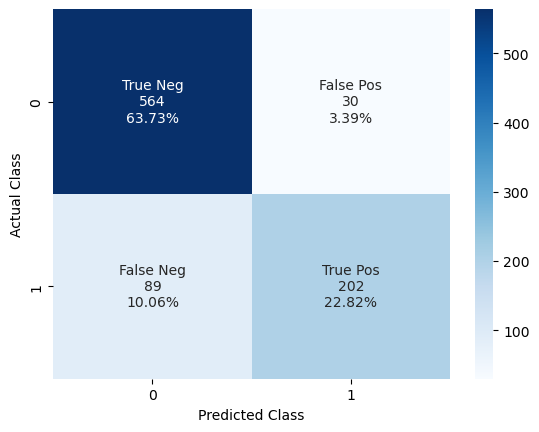

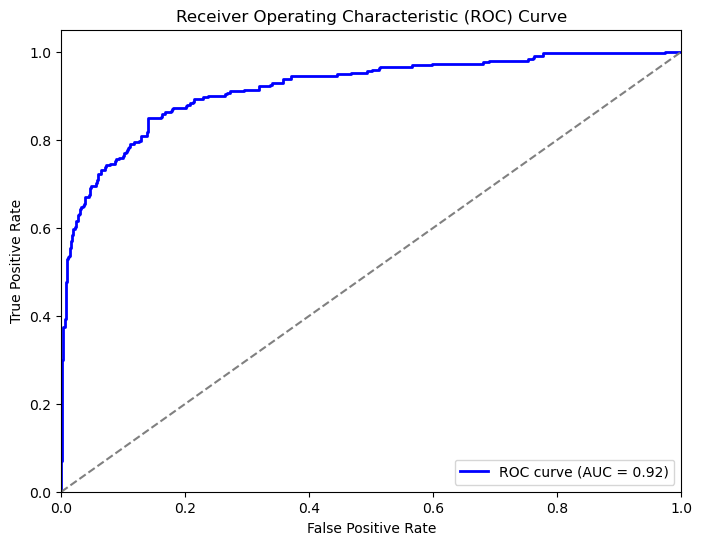

In [72]:
model_evaluation(best_cat_model, X_te = x_test, y_te = y_test, phase = 'Test')

In [73]:
save_model(best_cat_model, 'catboost.pkl')

Model saved successfully to catboost.pkl


# Extreme Gradient Boosting Classifier

In [74]:
from xgboost import XGBClassifier

In [75]:
xgb = XGBClassifier(random_state = 105)
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', xgb)  
])

Train Time(s): 4.207029700046405
Training Accuracy:  100.0%

 Model Evaluation Result For the Training Phase 

Test Time(s): 0.02196919987909496
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.81      0.74      0.77       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



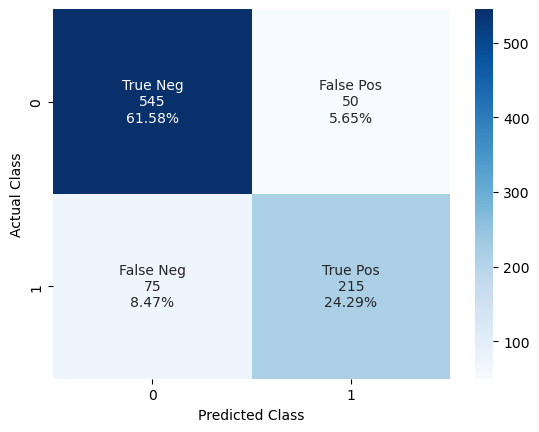

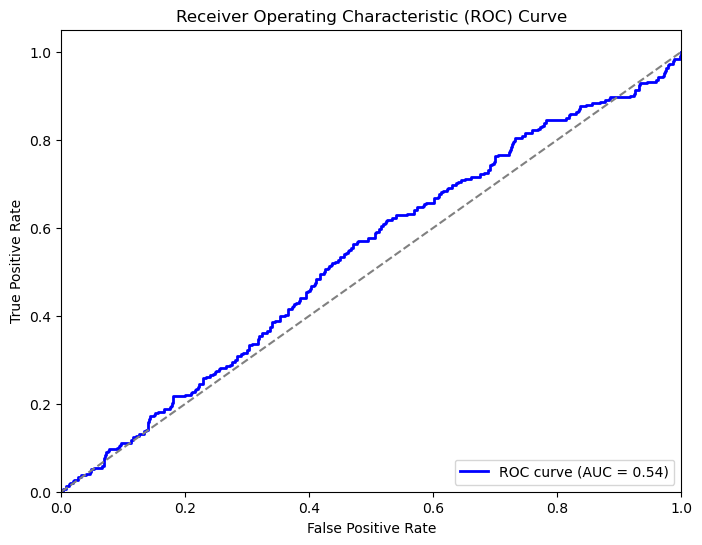

In [76]:
model_training(pipeline_xgb, x_train, y_train, x_val, y_val, phase = 'Training')

In [77]:
param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.3],
    'classifier__random_state' : [105]
}

random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,  # The pipeline containing preprocessing and classification steps
    param_distributions=param_grid_xgb,  # The parameter grid for random sampling
    n_iter=5,  # Number of random parameter settings to try
    cv=3,  # Number of cross-validation folds
    scoring= 'accuracy',  # Metric to evaluate the performance of the model
    n_jobs=-1,  # Use all available cores for computation
    verbose=1,  # Verbosity level, set to 1 to get progress updates
    random_state = 105
)

# Fit the RandomizedSearchCV object to the training data
# This will search for the best hyperparameters based on cross-validation performance
random_search_xgb.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importa...
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.7,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.3],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.3],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__n_estimators': [50, 100,
                                                                     200],
                                        'classifier__random_state': [105],
                                        'classifier__subsample': [0.7, 0.8,
                                                                  0.9]},
                   random_state=105, scoring='accuracy', verbose=1)

In [78]:
best_xgb_model = random_search_xgb.best_estimator_


 Model Evaluation Result For the Tuning Phase 

Test Time(s): 0.014871800085529685
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       595
           1       0.82      0.74      0.78       290

    accuracy                           0.86       885
   macro avg       0.85      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885
 



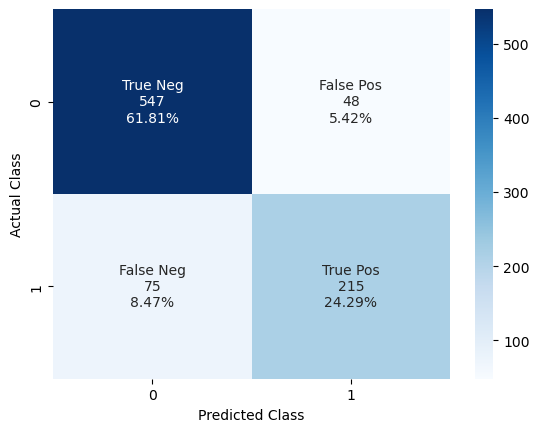

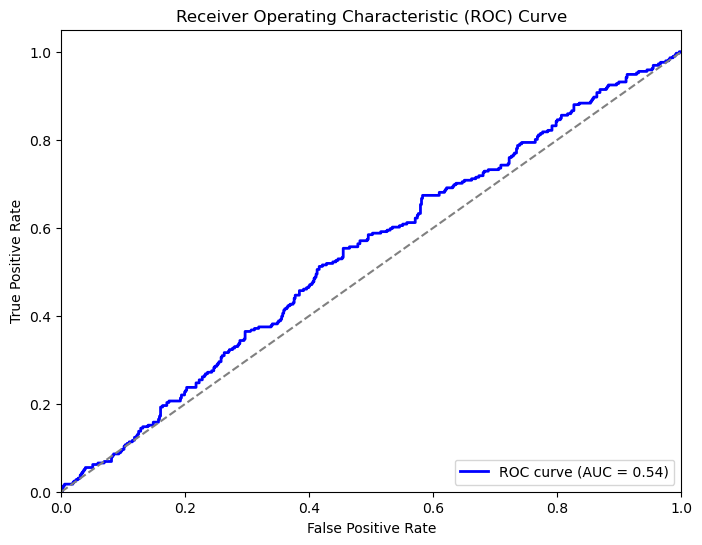

In [79]:
model_evaluation(best_xgb_model, X_te = x_val, y_te = y_val, phase = 'Tuning')

In [80]:
cross_validation(best_xgb_model, x_eval, y_eval, cv)

Scores: [0.88418079 0.86864407 0.87853107 0.87429379 0.85855728]
Mean: 0.8728414003627967
StandardDeviation: 0.008771740458213557



 Model Evaluation Result For the Test Phase 

Test Time(s): 0.02575309993699193
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       594
           1       0.85      0.71      0.78       291

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



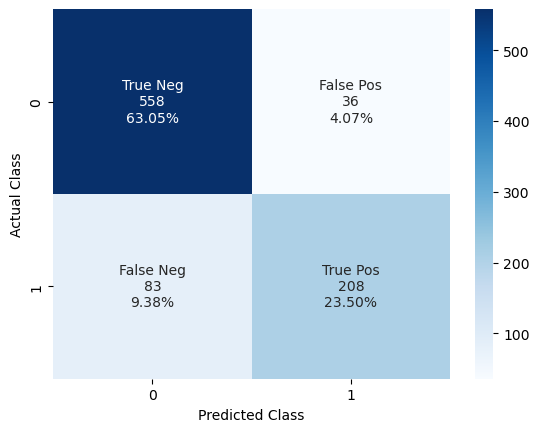

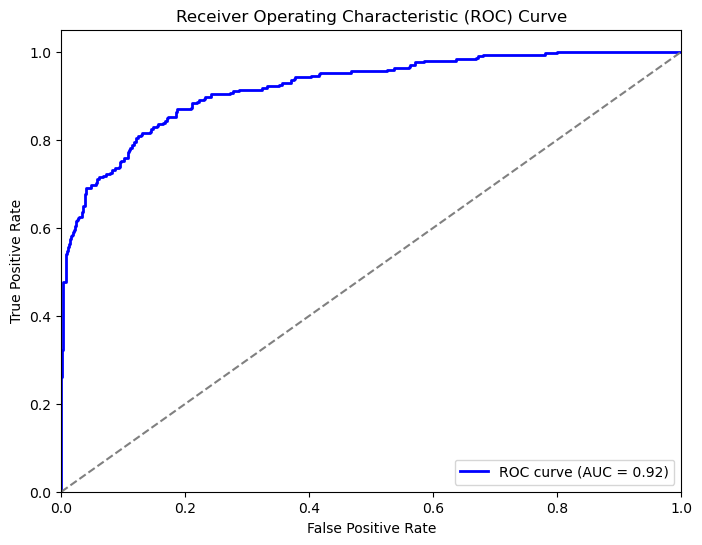

In [81]:
model_evaluation(best_xgb_model, X_te = x_test, y_te = y_test, phase = 'Test')

In [82]:
save_model(best_xgb_model, 'xgb.pkl')

Model saved successfully to xgb.pkl


# Deep Learning

In [83]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
def plot_loss_accuracy(history, figsize=(15, 10)):
    sns.set()  # Use seaborn styling for better aesthetics
    
    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot Training and Validation Accuracy on the first subplot
    ax1.plot(history.epoch, history.history["accuracy"], label='Training Accuracy', color='blue')
    ax1.plot(history.epoch, history.history["val_accuracy"], label='Validation Accuracy', color='orange')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Training and Validation Accuracy')

    # Plot Training and Validation Loss on the second subplot
    ax2.plot(history.epoch, history.history["loss"], label='Training Loss', color='green', linestyle='--')
    ax2.plot(history.epoch, history.history["val_loss"], label='Validation Loss', color='red', linestyle='--')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Training and Validation Loss')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()


In [85]:
def ANN_model_evaluation(clf, X_te, y_te, phase):
    print('\n Model Evaluation Result For the {} Phase \n'.format(phase))
    #Calculate start time for prediction
    start = timeit.default_timer()
        # Predict the model
    pred =clf.predict(X_te)
    pred_class = np.array([1 if i >= 0.5  else 0 for i in pred])

    #Calculate Stop time
    stop = timeit.default_timer()
    test_time= stop - start
    
#     print('Train Time(s):', train_time)

    #Test time
    print('Test Time(s):',test_time)
    
#     train_pred = clf.predict(X_tr)
    
#     train_acc = accuracy_score(y_tr, train_pred)
    
#     print('Training Accuracy:  {}%\n'.format(round(train_acc, 2)*100))
    
    accuracy = accuracy_score(y_te, pred_class)
    
    report = classification_report(y_te, pred_class)
    
    print('Accuracy:  {}%\n'.format(round(accuracy, 2)*100))
    
    print(report, '\n')
    
    cf_matrix = confusion_matrix(y_te, pred_class)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    y_pred_proba = pred.ravel()  # .ravel() to flatten the output

    # Calculate False Positive Rate, True Positive Rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()



In [86]:
def save_keras_model(model, filename):
    try:
        # Save the entire model (architecture + weights + optimizer state)
        model.save(filename)
        print(f"Keras model saved successfully to {filename}")
    except Exception as e:
        print(f"Error saving Keras model: {e}")


In [87]:
mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
x_val = mm.transform(x_val)
x_test = mm.transform(x_test)

In [88]:
import os
os.environ['PYTHONHASHSEED']=str(105)
tf.random.set_seed(105)

In [89]:
model = Sequential()
model.add(Dense(256, input_shape = (x_train.shape[1], ), activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [90]:
es = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 10,
                   verbose = 1, restore_best_weights = True, start_from_epoch = 20)

In [91]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [92]:
history_1 = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 4s 13ms/step - loss: 0.4526 - accuracy: 0.7977 - val_loss: 0.3807 - val_accuracy: 0.8407
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3407 - accuracy: 0.8659 - val_loss: 0.4305 - val_accuracy: 0.8068
Epoch 3/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3262 - accuracy: 0.8749 - val_loss: 0.3614 - val_accuracy: 0.8554
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3284 - accuracy: 0.8711 - val_loss: 0.3639 - val_accuracy: 0.8520
Epoch 5/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3209 - accuracy: 0.8738 - val_loss: 0.3477 - val_accuracy: 0.8633
Epoch 6/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3169 - accuracy: 0.8745 - val_loss: 0.3552 - val_accuracy: 0.8497
Epoch 7/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3146 - accuracy: 0.8734 - val_loss: 0.3794 - val_accuracy: 0.8531
Epoch 8/200


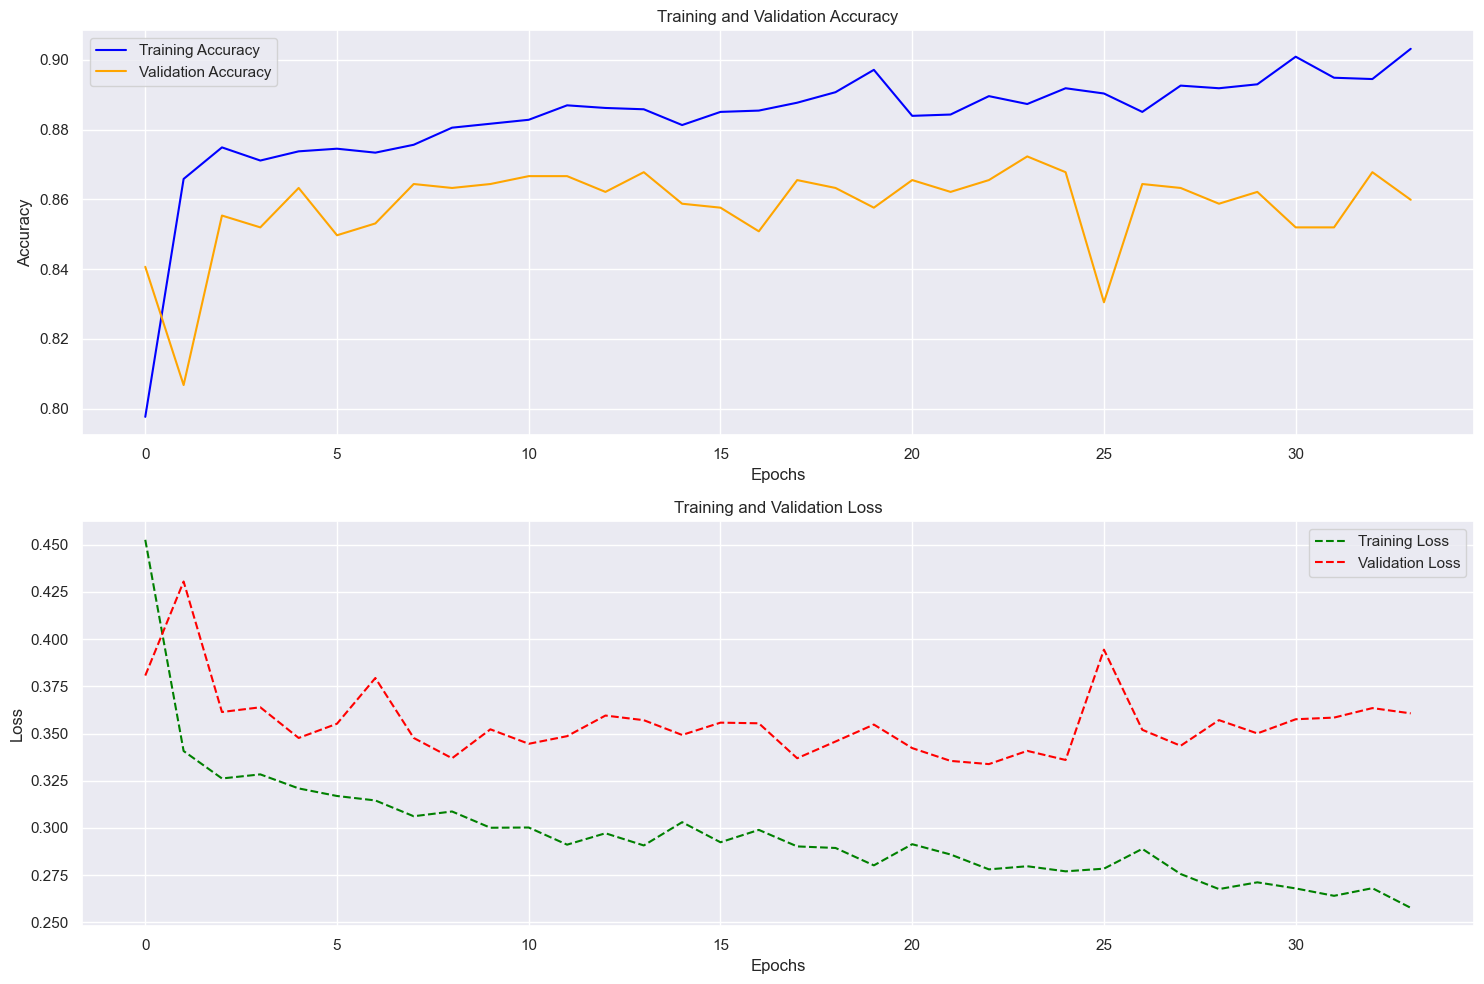

In [93]:
plot_loss_accuracy(history_1)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 3ms/step
Test Time(s): 0.38672910002060235
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       594
           1       0.85      0.72      0.78       291

    accuracy                           0.87       885
   macro avg       0.86      0.83      0.84       885
weighted avg       0.86      0.87      0.86       885
 



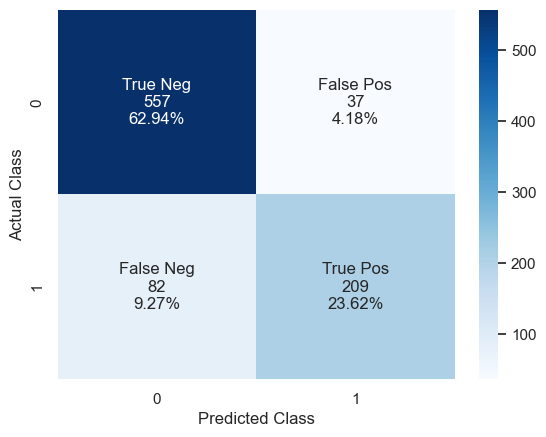

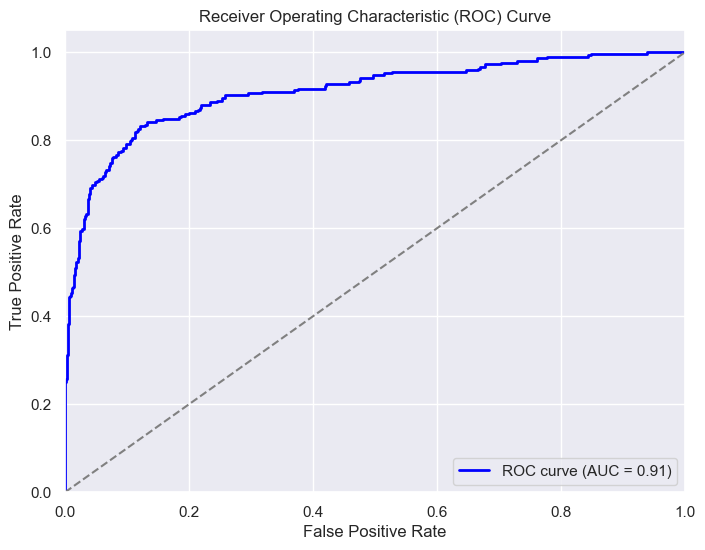

In [94]:
ANN_model_evaluation(model, x_test, y_test, phase = 'Test')

In [95]:
save_keras_model(model, 'model.h5')

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Keras model saved successfully to model.h5


In [96]:
plot_model(model, to_file="model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [97]:
model1 = Sequential()
model1.add(Dense(2048, input_shape = (x_train.shape[1], ), activation = 'relu'))
model1.add(Dense(1024, activation = 'relu'))
model1.add(Dense(512, activation = 'relu'))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

In [98]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [99]:
history_2 = model1.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 6s 81ms/step - loss: 0.4543 - accuracy: 0.8007 - val_loss: 0.3605 - val_accuracy: 0.8497
Epoch 2/200
42/42 [==============================] - 3s 73ms/step - loss: 0.3503 - accuracy: 0.8625 - val_loss: 0.3703 - val_accuracy: 0.8452
Epoch 3/200
42/42 [==============================] - 3s 63ms/step - loss: 0.3442 - accuracy: 0.8685 - val_loss: 0.3737 - val_accuracy: 0.8588
Epoch 4/200
42/42 [==============================] - 3s 66ms/step - loss: 0.3333 - accuracy: 0.8738 - val_loss: 0.3758 - val_accuracy: 0.8429
Epoch 5/200
42/42 [==============================] - 3s 64ms/step - loss: 0.3209 - accuracy: 0.8719 - val_loss: 0.3573 - val_accuracy: 0.8588
Epoch 6/200
42/42 [==============================] - 3s 63ms/step - loss: 0.3351 - accuracy: 0.8696 - val_loss: 0.3642 - val_accuracy: 0.8633
Epoch 7/200
42/42 [==============================] - 3s 70ms/step - loss: 0.3118 - accuracy: 0.8806 - val_loss: 0.3754 - val_accuracy: 0.8644
Epoch 

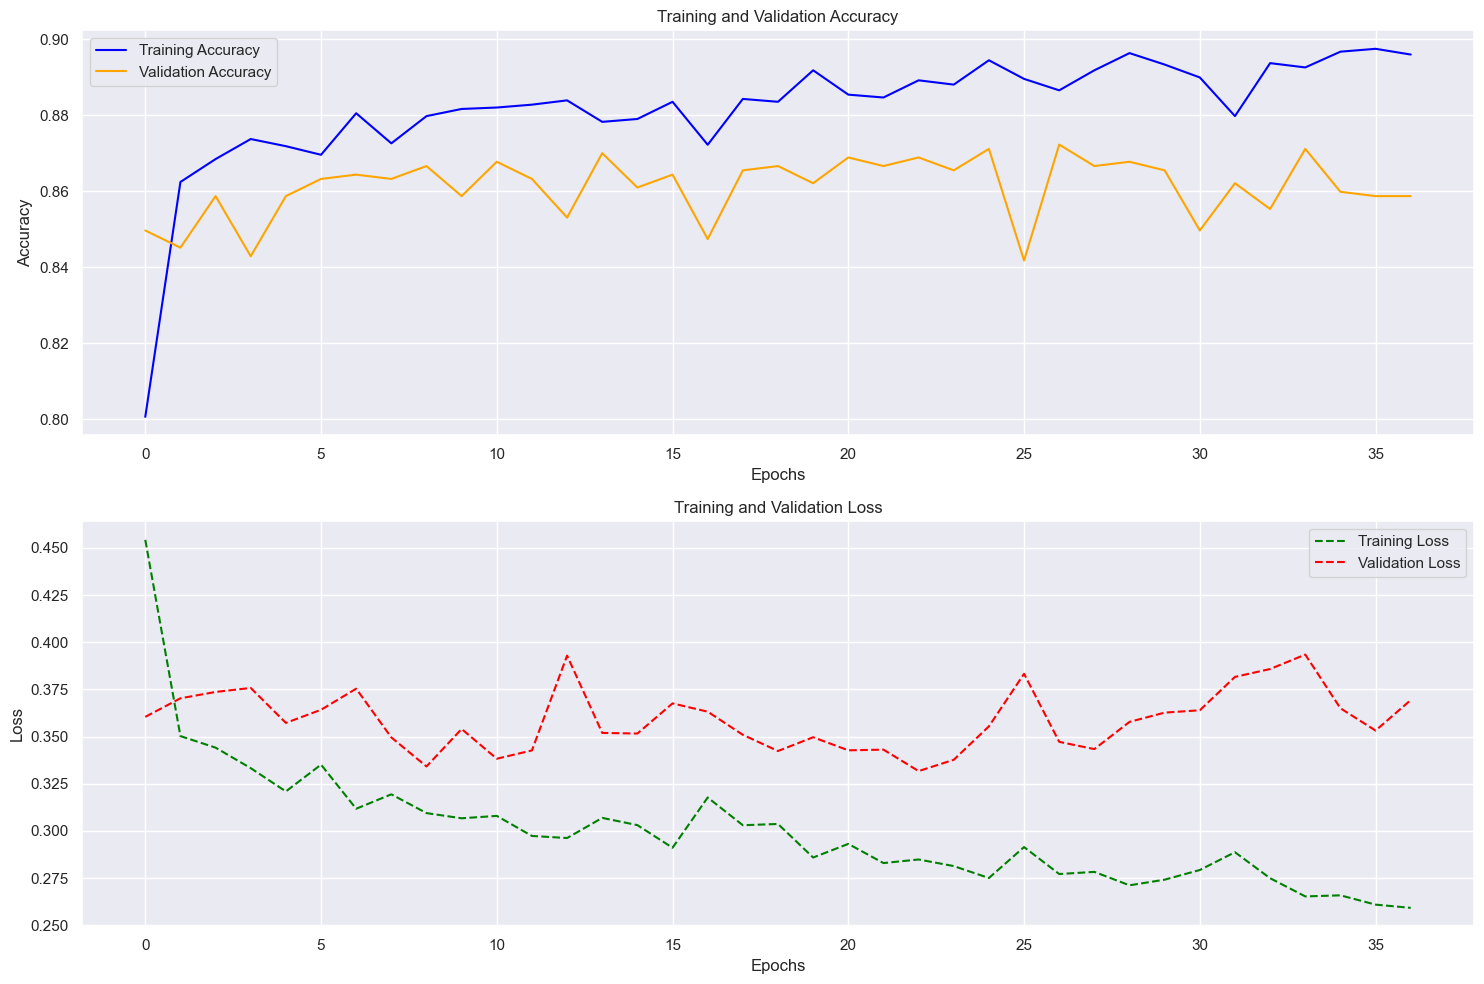

In [100]:
plot_loss_accuracy(history_2)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 8ms/step
Test Time(s): 0.429307600017637
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       594
           1       0.88      0.67      0.76       291

    accuracy                           0.86       885
   macro avg       0.87      0.81      0.83       885
weighted avg       0.86      0.86      0.86       885
 



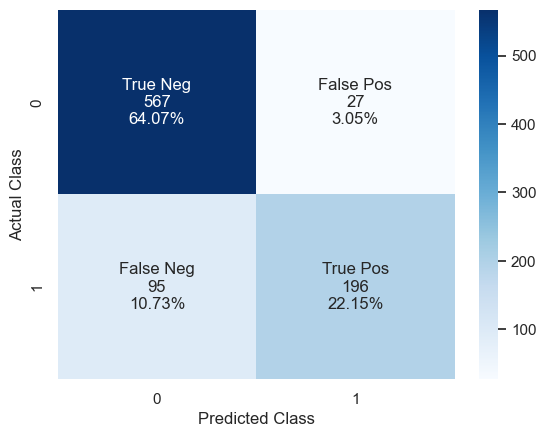

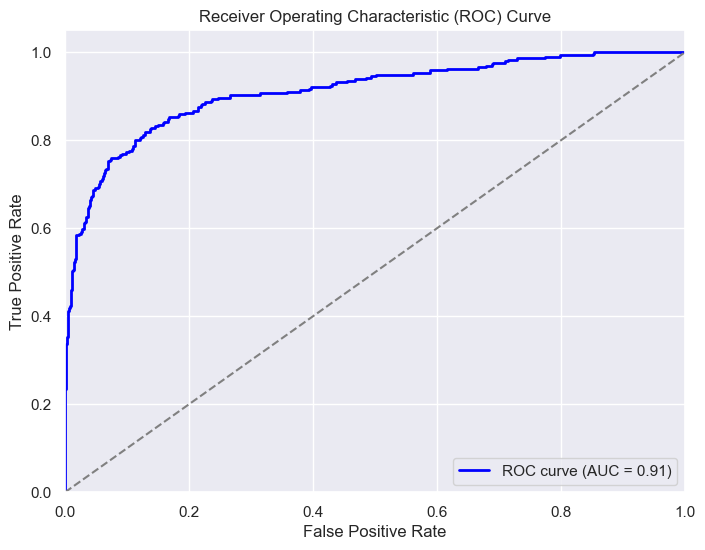

In [101]:
ANN_model_evaluation(model1, x_test, y_test, phase = 'Test')

In [102]:
save_keras_model(model, 'model1.h5')

Keras model saved successfully to model1.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
plot_model(model, to_file="model1.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [104]:
model_reg = Sequential()
model_reg.add(Dense(128, input_shape = (x_train.shape[1], ), activation = 'relu'))
model_reg.add(Dense(64, activation = 'relu'))
model_reg.add(Dense(8, activation = 'relu'))
model_reg.add(Dense(1, activation = 'sigmoid'))

In [105]:
model_reg.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [106]:
history_3 = model_reg.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 2s 9ms/step - loss: 0.6510 - accuracy: 0.7558 - val_loss: 0.6104 - val_accuracy: 0.8384
Epoch 2/200
42/42 [==============================] - 0s 4ms/step - loss: 0.5990 - accuracy: 0.8455 - val_loss: 0.5936 - val_accuracy: 0.8508
Epoch 3/200
42/42 [==============================] - 0s 5ms/step - loss: 0.5809 - accuracy: 0.8632 - val_loss: 0.5798 - val_accuracy: 0.8475
Epoch 4/200
42/42 [==============================] - 0s 4ms/step - loss: 0.5680 - accuracy: 0.8617 - val_loss: 0.5716 - val_accuracy: 0.8497
Epoch 5/200
42/42 [==============================] - 0s 5ms/step - loss: 0.5533 - accuracy: 0.8677 - val_loss: 0.5579 - val_accuracy: 0.8531
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.5422 - accuracy: 0.8719 - val_loss: 0.5417 - val_accuracy: 0.8621
Epoch 7/200
42/42 [==============================] - 0s 4ms/step - loss: 0.5293 - accuracy: 0.8749 - val_loss: 0.5299 - val_accuracy: 0.8667
Epoch 8/200
4

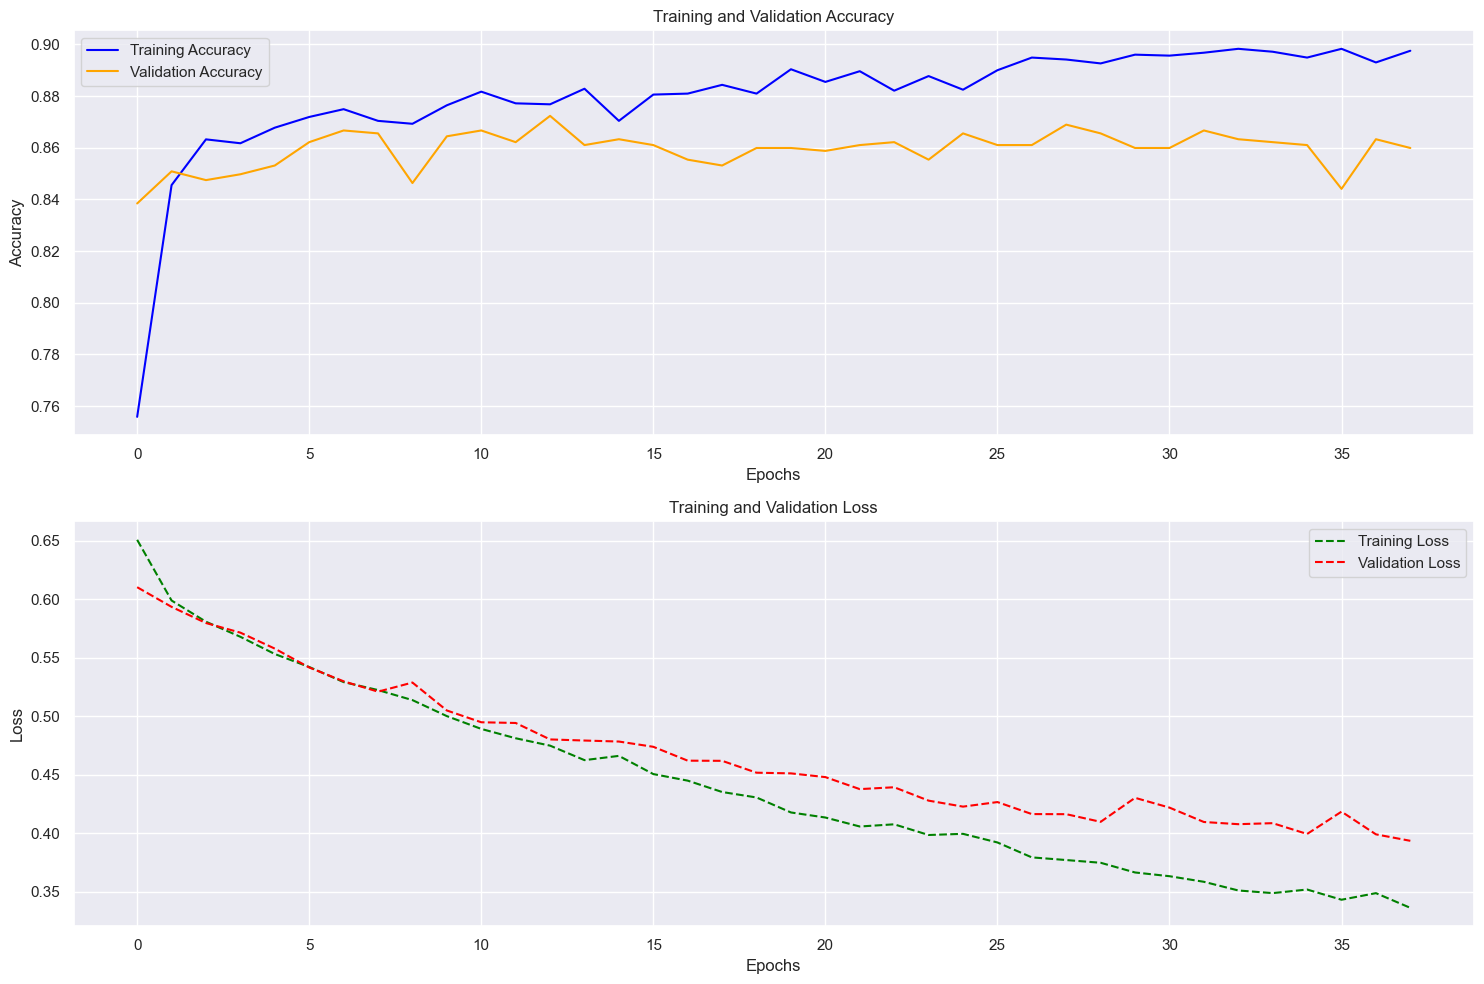

In [107]:
plot_loss_accuracy(history_3)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 3ms/step
Test Time(s): 0.3578347999136895
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.85      0.70      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



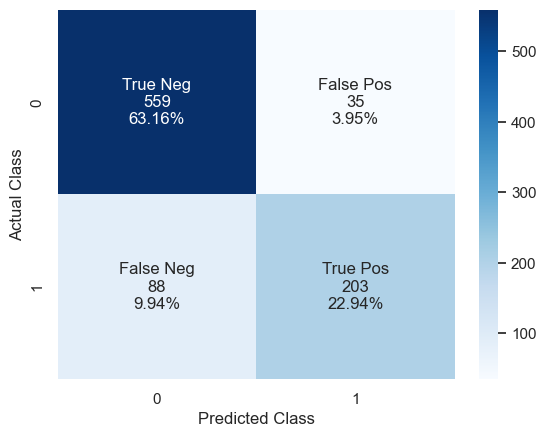

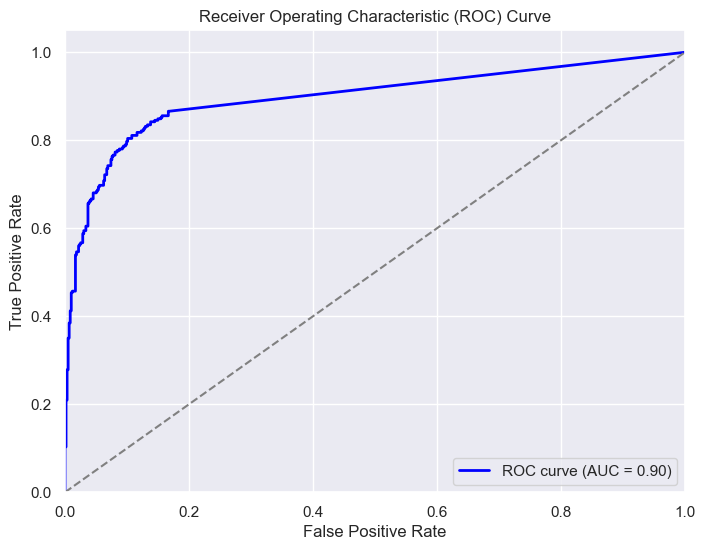

In [108]:
ANN_model_evaluation(model_reg, x_test, y_test, phase = 'Test')

In [109]:
save_keras_model(model, 'model2.h5')

Keras model saved successfully to model2.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
plot_model(model, to_file="model2.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [111]:
model_reg1 = Sequential()
model_reg1.add(Dense(256, input_shape = (x_train.shape[1], ), activation = 'relu'))
model_reg1.add(Dense(128, activation = 'relu'))
model_reg1.add(Dense(8, activation = 'relu'))
model_reg1.add(Dense(8, activation = 'relu'))
model_reg1.add(Dense(1, activation = 'sigmoid'))

In [112]:
model_reg1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_4 = model_reg1.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 3s 15ms/step - loss: 0.4529 - accuracy: 0.7939 - val_loss: 0.4045 - val_accuracy: 0.8328
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3436 - accuracy: 0.8655 - val_loss: 0.3739 - val_accuracy: 0.8486
Epoch 3/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3252 - accuracy: 0.8760 - val_loss: 0.3622 - val_accuracy: 0.8588
Epoch 4/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3359 - accuracy: 0.8681 - val_loss: 0.3670 - val_accuracy: 0.8554
Epoch 5/200
42/42 [==============================] - 0s 8ms/step - loss: 0.3229 - accuracy: 0.8723 - val_loss: 0.3470 - val_accuracy: 0.8565
Epoch 6/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3182 - accuracy: 0.8711 - val_loss: 0.3485 - val_accuracy: 0.8576
Epoch 7/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3165 - accuracy: 0.8749 - val_loss: 0.3645 - val_accuracy: 0.8576
Epoch 8/200


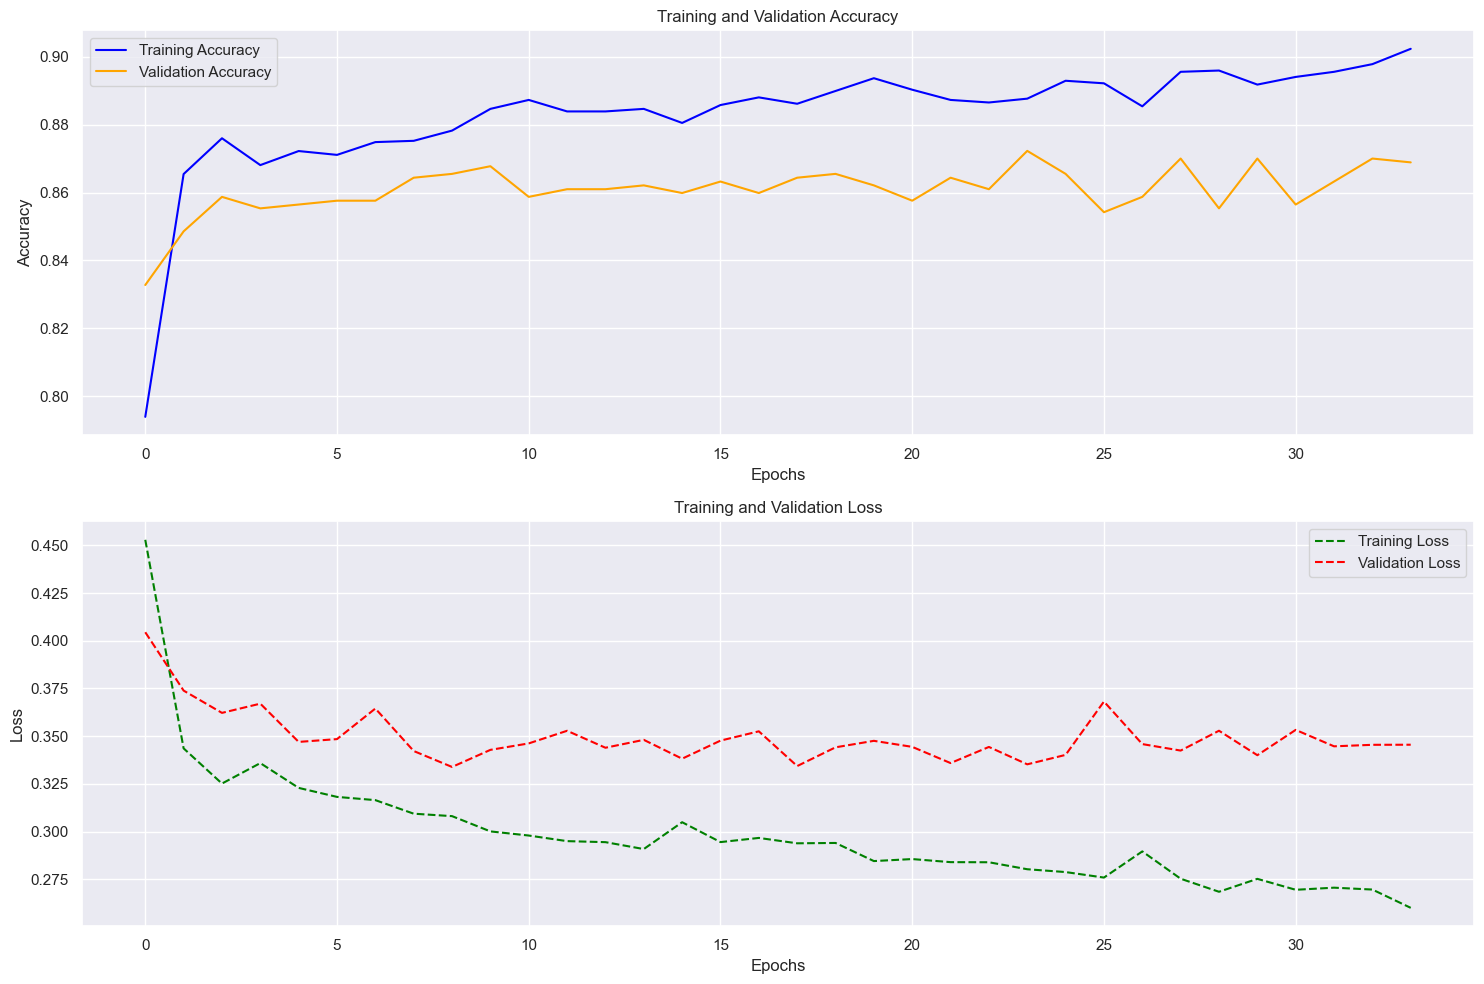

In [113]:
plot_loss_accuracy(history_4)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 3ms/step
Test Time(s): 0.4363413001410663
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.70      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.87      0.87      0.86       885
 



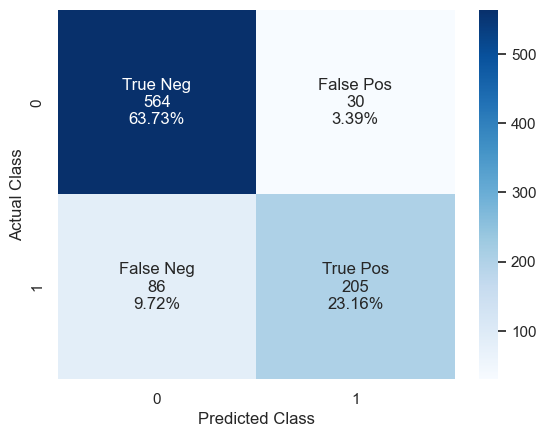

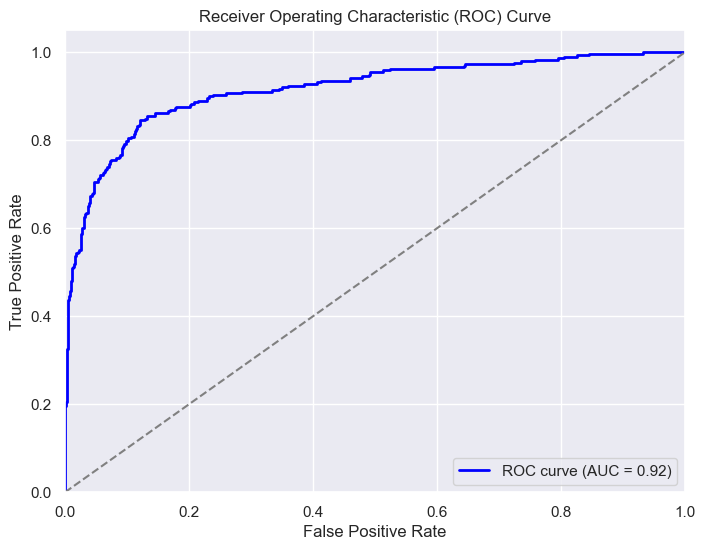

In [114]:
ANN_model_evaluation(model_reg1, x_test, y_test, phase = 'Test')

In [115]:
save_keras_model(model, 'model3.h5')

Keras model saved successfully to model3.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [116]:
plot_model(model, to_file="model3.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [117]:
model3 = Sequential()
model3.add(Dense(2048, input_shape = (x_train.shape[1], ), activation = 'relu'))
model3.add(Dense(1024, activation = 'relu'))
model3.add(Dense(512, activation = 'relu'))
model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dense(8, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

In [118]:
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_5 = model3.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 7s 87ms/step - loss: 0.6920 - accuracy: 0.6168 - val_loss: 0.6770 - val_accuracy: 0.6723
Epoch 2/200
42/42 [==============================] - 3s 81ms/step - loss: 0.5759 - accuracy: 0.7178 - val_loss: 0.4336 - val_accuracy: 0.8045
Epoch 3/200
42/42 [==============================] - 3s 80ms/step - loss: 0.3735 - accuracy: 0.8515 - val_loss: 0.3705 - val_accuracy: 0.8508
Epoch 4/200
42/42 [==============================] - 3s 77ms/step - loss: 0.3508 - accuracy: 0.8632 - val_loss: 0.3848 - val_accuracy: 0.8520
Epoch 5/200
42/42 [==============================] - 3s 83ms/step - loss: 0.3311 - accuracy: 0.8753 - val_loss: 0.3558 - val_accuracy: 0.8508
Epoch 6/200
42/42 [==============================] - 3s 78ms/step - loss: 0.3309 - accuracy: 0.8745 - val_loss: 0.3618 - val_accuracy: 0.8610
Epoch 7/200
42/42 [==============================] - 3s 71ms/step - loss: 0.3208 - accuracy: 0.8742 - val_loss: 0.3547 - val_accuracy: 0.8644
Epoch 

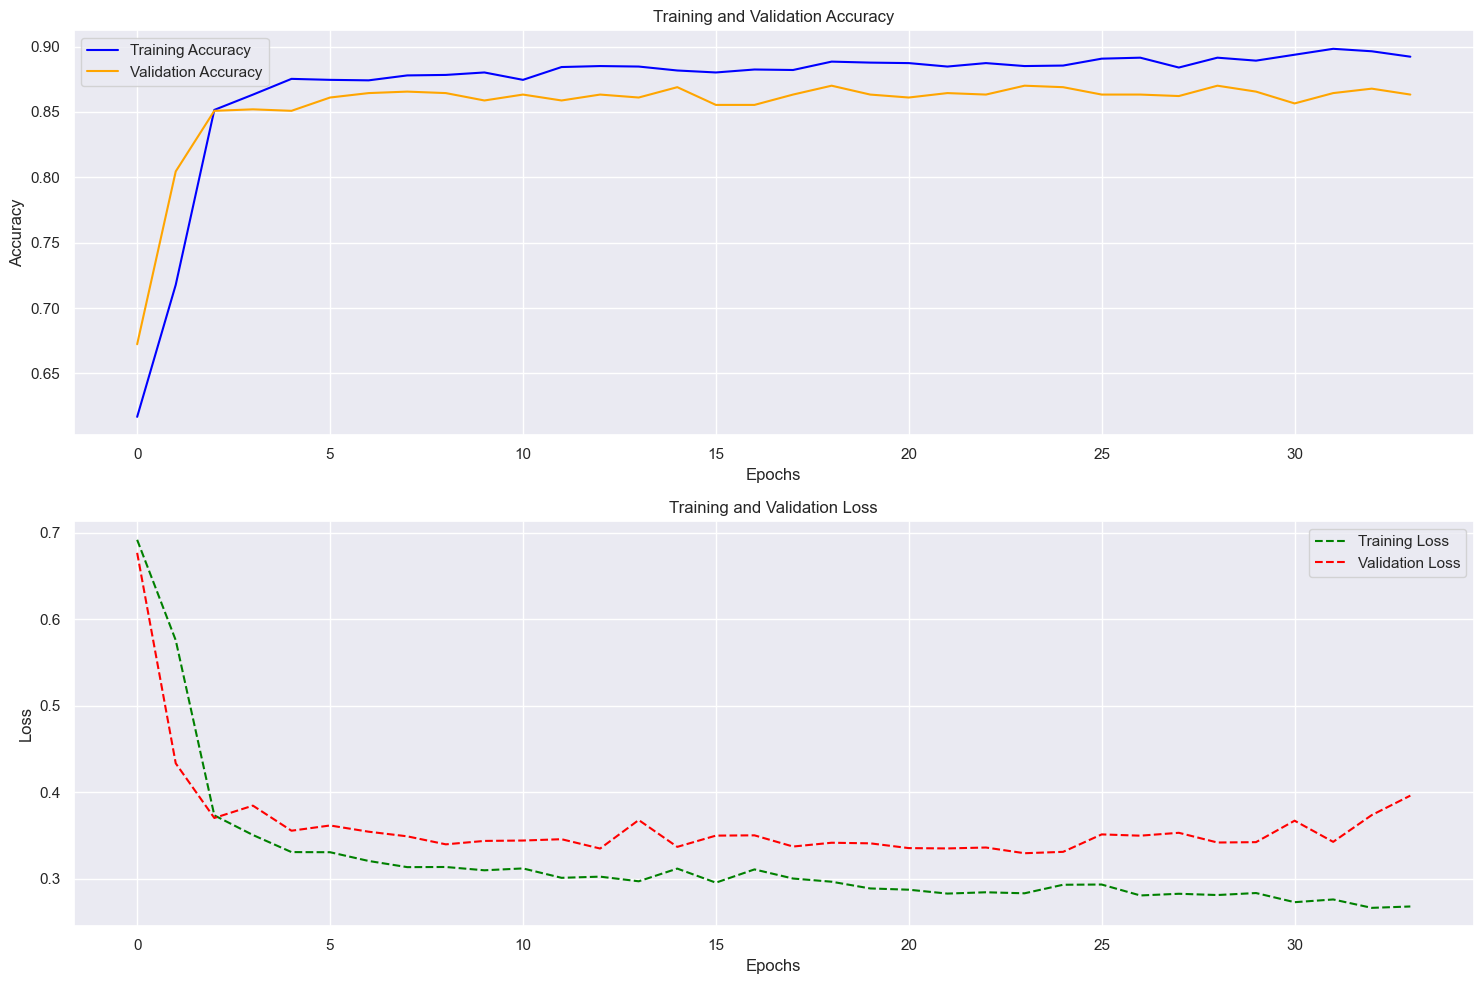

In [119]:
plot_loss_accuracy(history_5)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 9ms/step
Test Time(s): 0.5063753998838365
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       594
           1       0.87      0.67      0.76       291

    accuracy                           0.86       885
   macro avg       0.86      0.81      0.83       885
weighted avg       0.86      0.86      0.85       885
 



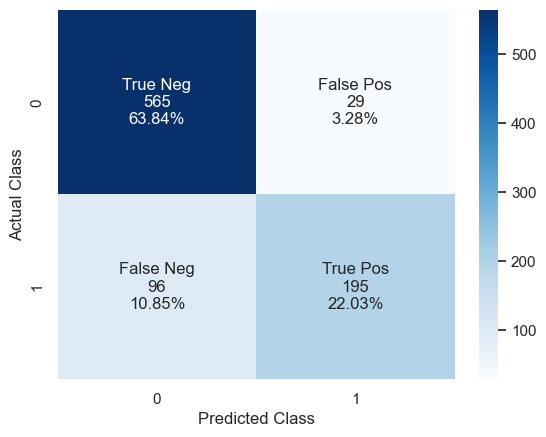

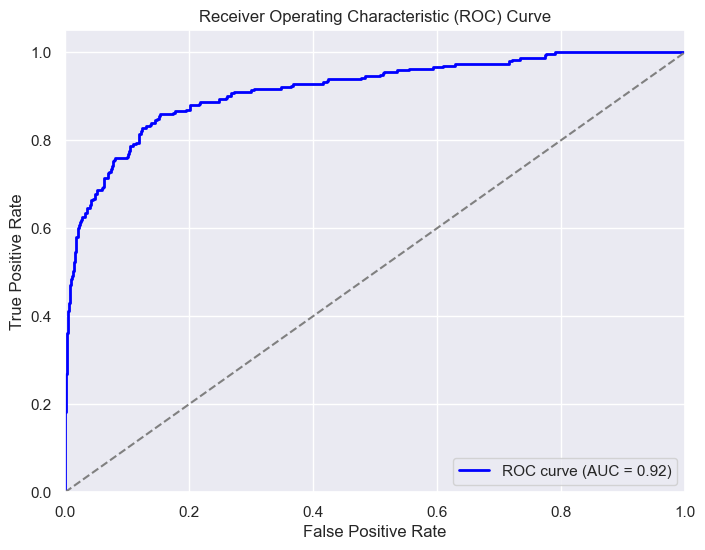

In [120]:
ANN_model_evaluation(model3, x_test, y_test, phase = 'Test')

In [121]:
save_keras_model(model, 'model4.h5')

Keras model saved successfully to model4.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [122]:
plot_model(model, to_file="model4.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [123]:
model4 = Sequential()
model4.add(Dense(4096, input_shape = (x_train.shape[1], ), activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(2048, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1024, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(512, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(8, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))

In [124]:
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_6 = model4.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 12s 223ms/step - loss: 0.5306 - accuracy: 0.7442 - val_loss: 0.4471 - val_accuracy: 0.8328
Epoch 2/200
42/42 [==============================] - 9s 218ms/step - loss: 0.3875 - accuracy: 0.8470 - val_loss: 0.4782 - val_accuracy: 0.7819
Epoch 3/200
42/42 [==============================] - 9s 209ms/step - loss: 0.3761 - accuracy: 0.8557 - val_loss: 0.3830 - val_accuracy: 0.8520
Epoch 4/200
42/42 [==============================] - 11s 262ms/step - loss: 0.3637 - accuracy: 0.8568 - val_loss: 0.3934 - val_accuracy: 0.8486
Epoch 5/200
42/42 [==============================] - 11s 253ms/step - loss: 0.3465 - accuracy: 0.8662 - val_loss: 0.3852 - val_accuracy: 0.8633
Epoch 6/200
42/42 [==============================] - 10s 250ms/step - loss: 0.3704 - accuracy: 0.8621 - val_loss: 0.3695 - val_accuracy: 0.8576
Epoch 7/200
42/42 [==============================] - 10s 238ms/step - loss: 0.3323 - accuracy: 0.8779 - val_loss: 0.3863 - val_accuracy: 0

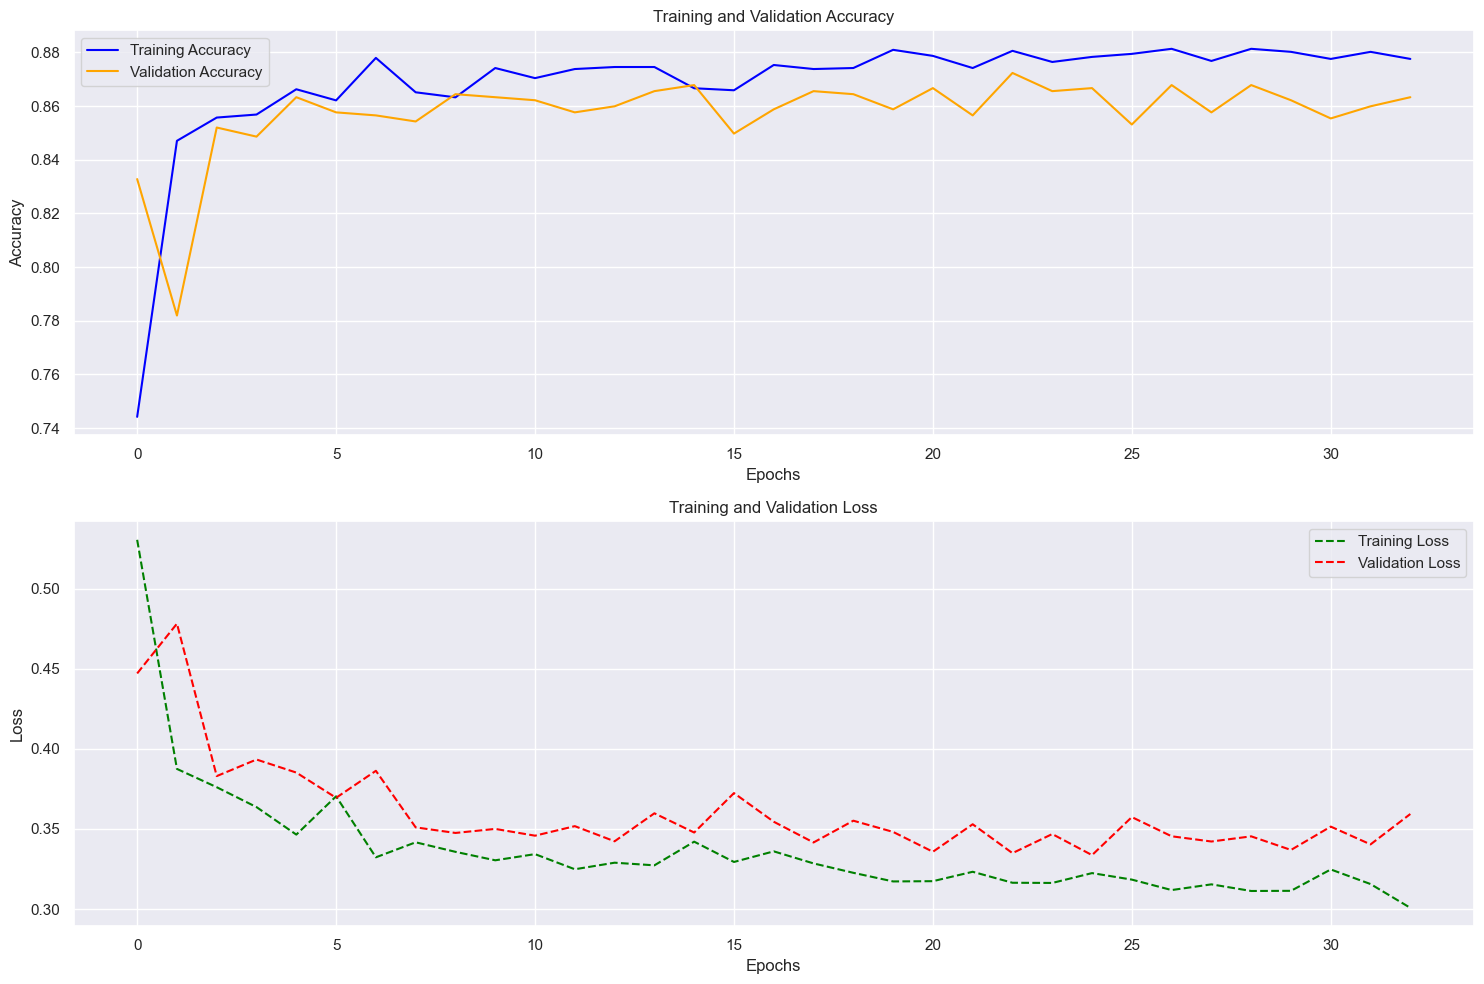

In [125]:
plot_loss_accuracy(history_6)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 1s 22ms/step
Test Time(s): 0.9198770998045802
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.90       594
           1       0.86      0.70      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.87      0.87      0.86       885
 



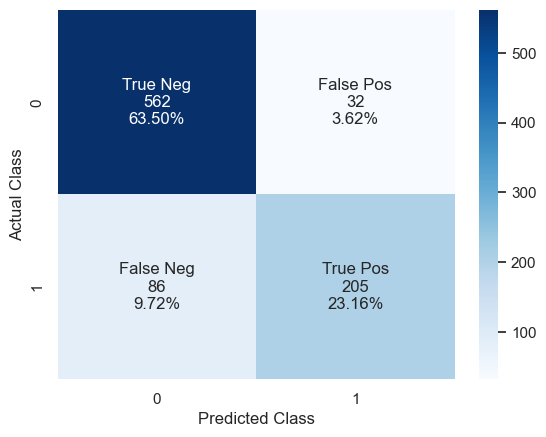

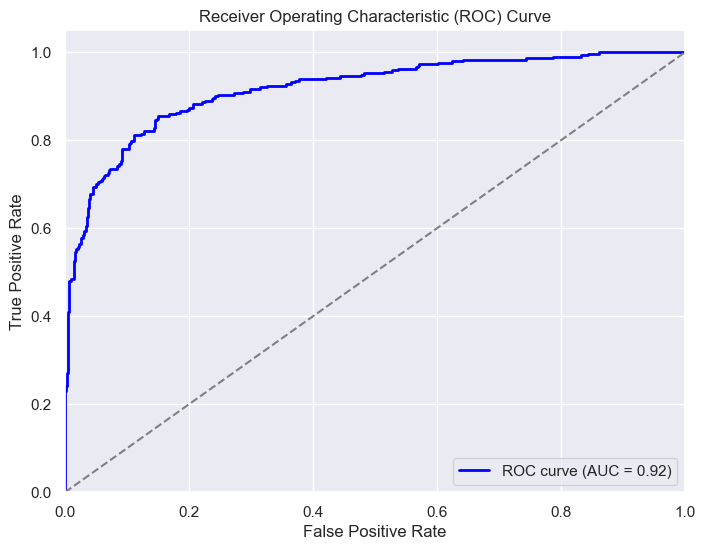

In [126]:
ANN_model_evaluation(model4, x_test, y_test, phase = 'Test')

In [127]:
save_keras_model(model, 'model5.h5')

Keras model saved successfully to model5.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [128]:
plot_model(model, to_file="model5.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [129]:
model5 = Sequential()
model5.add(Dense(4, input_shape = (x_train.shape[1], ), activation = 'relu'))
model5.add(Dense(16, activation = 'relu'))
model5.add(Dense(16, activation = 'relu'))
model5.add(Dense(64, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(1, activation = 'sigmoid'))

In [130]:
model5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_7 = model5.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 3s 21ms/step - loss: 0.4935 - accuracy: 0.7683 - val_loss: 0.4759 - val_accuracy: 0.7898
Epoch 2/200
42/42 [==============================] - 1s 13ms/step - loss: 0.3874 - accuracy: 0.8399 - val_loss: 0.4076 - val_accuracy: 0.8158
Epoch 3/200
42/42 [==============================] - 1s 14ms/step - loss: 0.3513 - accuracy: 0.8595 - val_loss: 0.3738 - val_accuracy: 0.8429
Epoch 4/200
42/42 [==============================] - 1s 14ms/step - loss: 0.3346 - accuracy: 0.8693 - val_loss: 0.3696 - val_accuracy: 0.8565
Epoch 5/200
42/42 [==============================] - 1s 12ms/step - loss: 0.3293 - accuracy: 0.8749 - val_loss: 0.3587 - val_accuracy: 0.8565
Epoch 6/200
42/42 [==============================] - 1s 14ms/step - loss: 0.3262 - accuracy: 0.8753 - val_loss: 0.3612 - val_accuracy: 0.8576
Epoch 7/200
42/42 [==============================] - 1s 13ms/step - loss: 0.3243 - accuracy: 0.8753 - val_loss: 0.3536 - val_accuracy: 0.8565
Epoch 

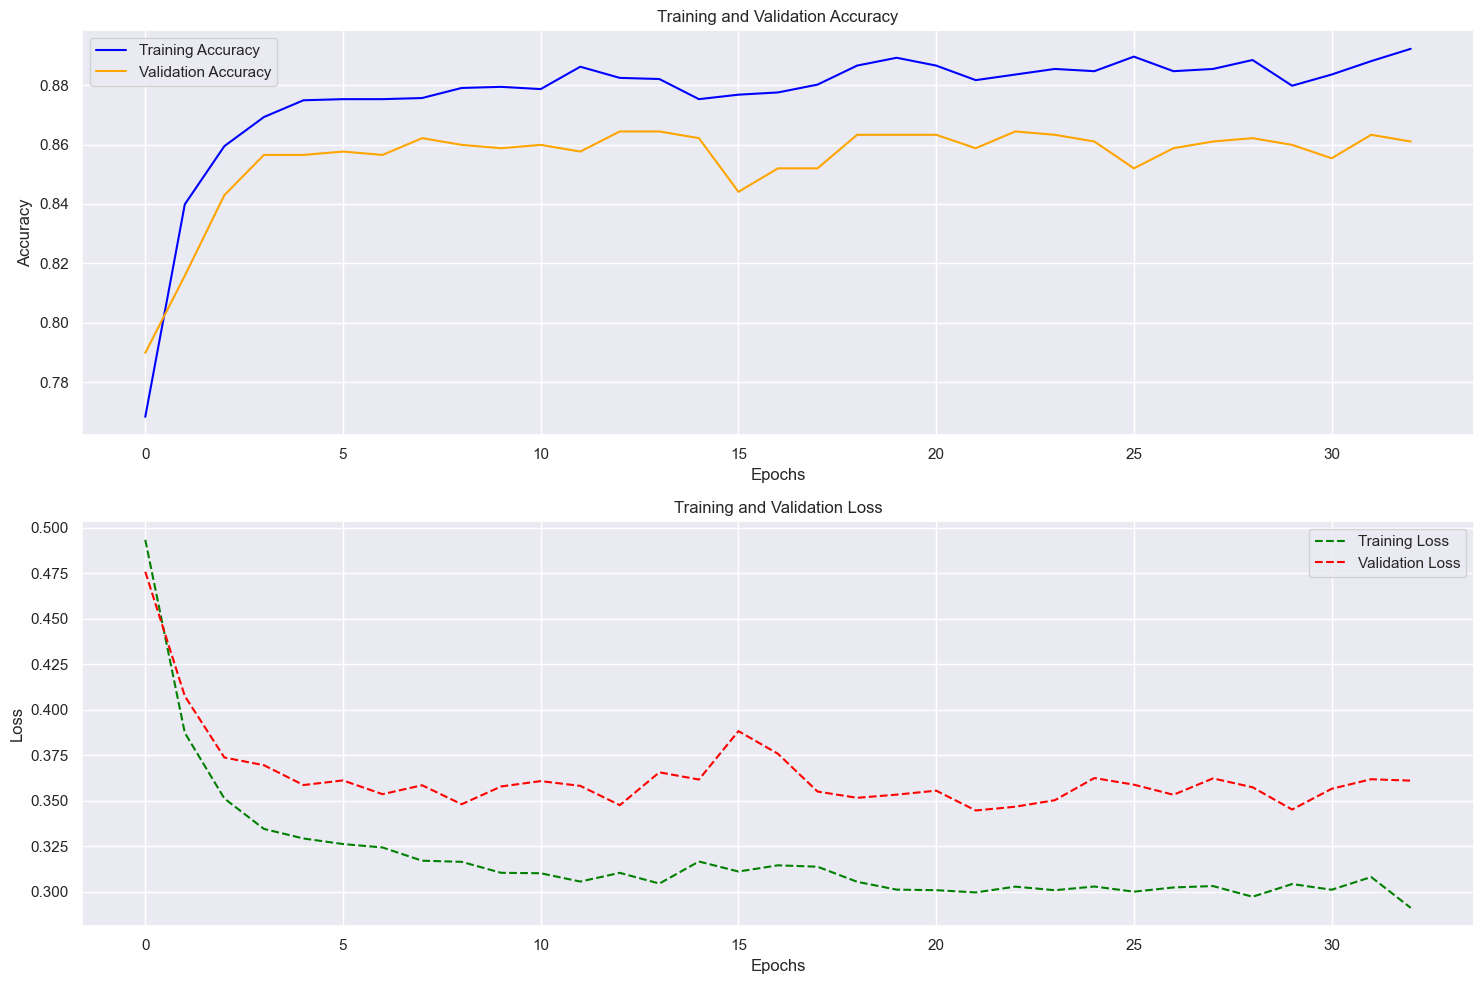

In [131]:
plot_loss_accuracy(history_7)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 3ms/step
Test Time(s): 0.3614670999813825
Accuracy:  88.0%

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       594
           1       0.88      0.75      0.81       291

    accuracy                           0.88       885
   macro avg       0.88      0.85      0.86       885
weighted avg       0.88      0.88      0.88       885
 



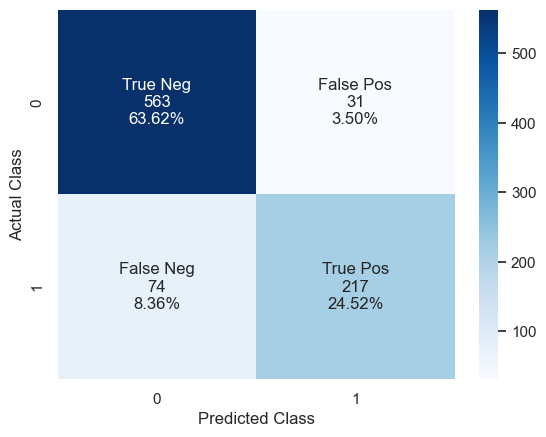

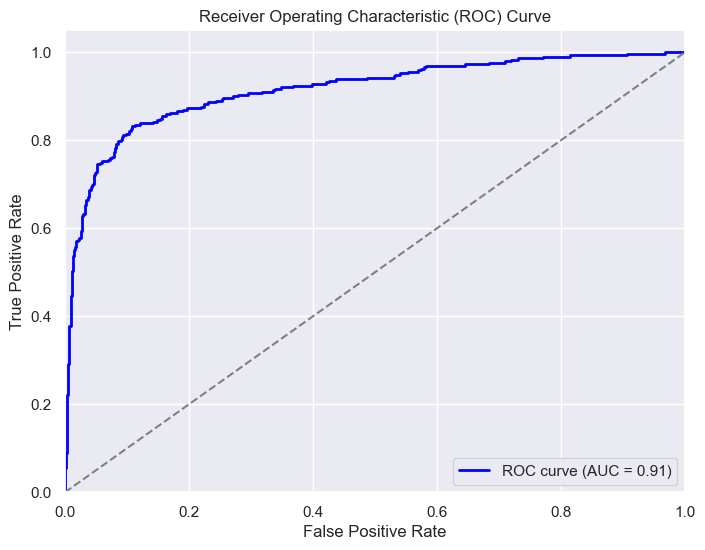

In [132]:
ANN_model_evaluation(model5, x_test, y_test, phase = 'Test')

In [133]:
save_keras_model(model, 'model6.h5')

Keras model saved successfully to model6.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [134]:
plot_model(model, to_file="model6.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
